In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_1_Original/train.py
import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# paths / constants
DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_1_Original"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(OUT_ROOT / "hyperparams.json", "w") as f:
    json.dump({
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN}
    }, f, indent=2)

# data
def _labels(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

class UTIKeepM(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path).astype(np.float32)  # [N,C,T,V,M]
        self.y = _labels(y_path)
        self.N = self.x.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, i):
        return torch.from_numpy(self.x[i]), torch.tensor(int(self.y[i]), dtype=torch.long)

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp, yp = split_dir / f"{kind}_data.npy", split_dir / f"{kind}_label.npy"
    ds = UTIKeepM(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                    drop_last=(kind=="train"))
    return ds, dl

# graph
def _coco17_edges():
    E = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            if 0 <= u < V and 0 <= v < V:
                A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

A_PATH = OUT_ROOT / f"adjacency_V{V_IN}.npy"
if not A_PATH.exists():
    np.save(A_PATH, normalized_adjacency(V_IN).cpu().numpy())

# model (graph conv + temporal conv)
class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)            # [V,V]
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias)  # channel mix

    def forward(self, x):                       # x: [N,C,T,V]
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class STGCNBlock(nn.Module):
    def __init__(self, c_in, c_out, A, t_kernel=9, stride_t=1, dropout=DROPOUT):
        super().__init__()
        pad_t = t_kernel // 2
        self.gcn = GraphConv(c_in, c_out, A)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.do  = nn.Dropout(dropout)
        self.tcn = nn.Conv2d(c_out, c_out, kernel_size=(t_kernel,1),
                             stride=(stride_t,1), padding=(pad_t,0), bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )

    def forward(self, x):                       # x: [N,C,T,V]
        r = self.res(x)
        x = self.gcn(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.do(x)
        x = self.tcn(x)
        x = self.bn2(x)
        x = F.relu(x + r, inplace=True)
        return x

class STGCNBaseline(nn.Module):
    def __init__(self, c_in, num_classes, V=V_IN, t_kernel=9):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(c_in, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.layer1 = STGCNBlock(64,  64,  A, t_kernel=t_kernel, stride_t=1, dropout=DROPOUT)
        self.layer2 = STGCNBlock(64,  128, A, t_kernel=t_kernel, stride_t=2, dropout=DROPOUT)
        self.layer3 = STGCNBlock(128, 128, A, t_kernel=t_kernel, stride_t=1, dropout=DROPOUT)
        self.layer4 = STGCNBlock(128, 256, A, t_kernel=t_kernel, stride_t=2, dropout=DROPOUT)
        self.layer5 = STGCNBlock(256, 256, A, t_kernel=t_kernel, stride_t=1, dropout=DROPOUT)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pre = nn.Dropout(DROPOUT)
        self.fc  = nn.Linear(256, num_classes)

    def forward(self, x):                       # x: [N,C,T,V,M]
        if x.dim() == 5:
            x = x.sum(dim=-1)                  # fuse persons
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.gap(x).flatten(1)
        x = self.pre(x)
        return self.fc(x)

# eval / train
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pr = model(xb).argmax(1)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(pr.cpu().tolist())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep  = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

class EarlyStopper:
    def __init__(self, patience):
        self.patience, self.best, self.count, self.stop = patience, -1e9, 0, False
    def step(self, v):
        if v > self.best:
            self.best, self.count = v, 0
            return True
        self.count += 1
        if self.count >= self.patience: self.stop = True
        return False

def train_one_fold(k:int):
    fold_dir = FOLDS_ROOT / f"fold{k}"
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_dir, "train", True)
    va_ds, va_dl = make_loader(fold_dir, "val")
    te_ds, te_dl = make_loader(fold_dir, "test")

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = STGCNBaseline(c_in=C_IN, num_classes=num_classes).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = nn.CrossEntropyLoss()(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()
        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct  / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep, "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"], "val_prec": val["prec"],
            "val_rec": val["rec"], "val_f1": val["f1"],
            "val_prec_w": val["prec_w"], "val_rec_w": val["rec_w"], "val_f1_w": val["f1_w"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"Running Model_1_Original | FOLD {k} | Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"Running Model_1_Original | FOLD {k} | Early stopping at epoch {ep}")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro": float(test["prec"]),
            "test_recall_macro": float(test["rec"]),
            "test_f1_macro": float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted": float(test["rec_w"]),
            "test_f1_weighted": float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "test_prec_w": float(test["prec_w"]),
        "test_rec_w": float(test["rec_w"]),
        "test_f1_w": float(test["f1_w"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_1_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_1_Original"]
        rows.extend(old.to_dict("records"))
    m = {
        "Model": "Model_1_Original",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Mean Test Prec_w": np.mean([r["test_prec_w"] for r in all_reports]),
        "Mean Test Rec_w":  np.mean([r["test_rec_w"]  for r in all_reports]),
        "Mean Test F1_w":   np.mean([r["test_f1_w"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    }
    rows.append(m)
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\n DONE (Model_1_Original) ")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 1 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

/tmp/ipython-input-593937378.py:243: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss_sum += float(loss) * yb.size(0)


Running Model_1_Original | FOLD 1 | Ep001 tr_loss=1.9059 tr_acc=0.156 val_acc=0.000 val_f1=0.000 best=0.000@1
Running Model_1_Original | FOLD 1 | Ep005 tr_loss=0.8525 tr_acc=0.609 val_acc=0.083 val_f1=0.062 best=0.083@5
Running Model_1_Original | FOLD 1 | Ep008 tr_loss=0.6683 tr_acc=0.734 val_acc=0.167 val_f1=0.100 best=0.167@8
Running Model_1_Original | FOLD 1 | Ep010 tr_loss=0.8659 tr_acc=0.547 val_acc=0.167 val_f1=0.100 best=0.167@8
Running Model_1_Original | FOLD 1 | Ep011 tr_loss=0.7466 tr_acc=0.656 val_acc=0.500 val_f1=0.340 best=0.500@11
Running Model_1_Original | FOLD 1 | Ep012 tr_loss=0.6473 tr_acc=0.719 val_acc=0.583 val_f1=0.362 best=0.583@12
Running Model_1_Original | FOLD 1 | Ep015 tr_loss=0.7706 tr_acc=0.625 val_acc=0.583 val_f1=0.362 best=0.583@12
Running Model_1_Original | FOLD 1 | Ep020 tr_loss=0.6114 tr_acc=0.781 val_acc=0.500 val_f1=0.320 best=0.583@12
Running Model_1_Original | FOLD 1 | Ep025 tr_loss=0.6590 tr_acc=0.688 val_acc=0.583 val_f1=0.373 best=0.583@12
Runni

In [3]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_2_Original_MultiStream/train.py
import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_2_Original_MultiStream"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN_MEMORY    = DEVICE.type == "cuda"
DROPOUT       = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(OUT_ROOT / "hyperparams.json", "w") as f:
    json.dump({
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN},
        "backbone": "ST-GCN per stream, logits averaged"
    }, f, indent=2)

def to_motion(x: np.ndarray) -> np.ndarray:
    m = np.zeros_like(x, dtype=np.float32)
    m[:, :, 1:, :, :] = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    return m

def to_bone_center(x: np.ndarray) -> np.ndarray:
    center = x.mean(axis=3, keepdims=True)
    return (x - center).astype(np.float32)

def to_bone_motion(b: np.ndarray) -> np.ndarray:
    return to_motion(b)

def _np_load_labels(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

class UTIStreams(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.joint = np.load(x_path).astype(np.float32)
        self.y     = _np_load_labels(y_path)
        self.motion   = to_motion(self.joint)
        self.bone     = to_bone_center(self.joint)
        self.bone_mot = to_bone_motion(self.bone)
        self.N = self.joint.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, idx):
        x = {
            "joint":       torch.from_numpy(self.joint[idx]),
            "motion":      torch.from_numpy(self.motion[idx]),
            "bone":        torch.from_numpy(self.bone[idx]),
            "bone_motion": torch.from_numpy(self.bone_mot[idx]),
        }
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIStreams(Xp, yp)
    dl = DataLoader(
        ds, batch_size=BATCH_SIZE, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=(kind=="train")
    )
    return ds, dl

def _coco17_edges():
    E = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias)
    def forward(self, x):
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class STGCNBlock(nn.Module):
    def __init__(self, c_in, c_out, A, t_kernel=9, stride_t=1, dropout=DROPOUT):
        super().__init__()
        pad_t = t_kernel // 2
        self.gcn = GraphConv(c_in, c_out, A)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.do  = nn.Dropout(dropout)
        self.tcn = nn.Conv2d(c_out, c_out, kernel_size=(t_kernel,1),
                             stride=(stride_t,1), padding=(pad_t,0), bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )
    def forward(self, x):
        r = self.res(x)
        x = self.gcn(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.do(x)
        x = self.tcn(x)
        x = self.bn2(x)
        x = F.relu(x + r, inplace=True)
        return x

class StreamGCNHead(nn.Module):
    def __init__(self, in_ch, V, num_classes, t_kernel=9, dropout=DROPOUT):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.layer1 = STGCNBlock(64,  64,  A, t_kernel=t_kernel, stride_t=1, dropout=dropout)
        self.layer2 = STGCNBlock(64,  128, A, t_kernel=t_kernel, stride_t=2, dropout=dropout)
        self.layer3 = STGCNBlock(128, 128, A, t_kernel=t_kernel, stride_t=1, dropout=dropout)
        self.layer4 = STGCNBlock(128, 256, A, t_kernel=t_kernel, stride_t=2, dropout=dropout)
        self.layer5 = STGCNBlock(256, 256, A, t_kernel=t_kernel, stride_t=1, dropout=dropout)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pre = nn.Dropout(dropout)
        self.fc  = nn.Linear(256, num_classes)
    def forward(self, x):
        if x.dim()==5:
            x = x.sum(dim=-1)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.gap(x).flatten(1)
        x = self.pre(x)
        return self.fc(x)

class MultiStreamSTGCN(nn.Module):
    def __init__(self, in_ch, V, M, num_classes, t_kernel=9, dropout=DROPOUT):
        super().__init__()
        self.V = V
        self.M = M
        self.heads = nn.ModuleDict({
            "joint":       StreamGCNHead(in_ch, V, num_classes, t_kernel, dropout),
            "motion":      StreamGCNHead(in_ch, V, num_classes, t_kernel, dropout),
            "bone":        StreamGCNHead(in_ch, V, num_classes, t_kernel, dropout),
            "bone_motion": StreamGCNHead(in_ch, V, num_classes, t_kernel, dropout),
        })
    def forward(self, xb):
        logits = []
        for k in self.heads.keys():
            lg = self.heads[k](xb[k])
            logits.append(lg)
        return torch.stack(logits, dim=0).mean(dim=0)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = {k: v.to(DEVICE) for k, v in xb.items()}
        yb = yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep    = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fold_dir = FOLDS_ROOT / f"fold{k}"
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_dir, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_dir, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_dir, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = MultiStreamSTGCN(in_ch=C_IN, V=V_IN, M=M_IN, num_classes=num_classes, t_kernel=9, dropout=DROPOUT).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb = {k: v.to(DEVICE) for k, v in xb.items()}
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"], "val_prec": val["prec"], "val_rec": val["rec"], "val_f1": val["f1"],
            "val_prec_w": val["prec_w"], "val_rec_w": val["rec_w"], "val_f1_w": val["f1_w"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({"best_epoch": int(best_ep), "best_val_acc": float(best_val)}, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"Running Model_2_Original_MultiStream (ST-GCN) | FOLD {k} | Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"Running Model_2_Original_MultiStream (ST-GCN) | FOLD {k} | Early stopping at epoch {ep}")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro": float(test["prec"]),
            "test_recall_macro": float(test["rec"]),
            "test_f1_macro": float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted": float(test["rec_w"]),
            "test_f1_weighted": float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "test_prec_w": float(test["prec_w"]),
        "test_rec_w": float(test["rec_w"]),
        "test_f1_w": float(test["f1_w"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_2_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_2_Original_MultiStream"]
        rows.extend(old.to_dict("records"))
    m = {
        "Model": "Model_2_Original_MultiStream",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Mean Test Prec_w": np.mean([r["test_prec_w"] for r in all_reports]),
        "Mean Test Rec_w":  np.mean([r["test_rec_w"]  for r in all_reports]),
        "Mean Test F1_w":   np.mean([r["test_f1_w"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    }
    rows.append(m)
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\n DONE (Model_2_Original_MultiStream, ST-GCN) ")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 2 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep001 tr_loss=1.8340 tr_acc=0.188 val_acc=0.000 val_f1=0.000 best=0.000@1
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep002 tr_loss=1.3395 tr_acc=0.469 val_acc=0.083 val_f1=0.100 best=0.083@2
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep003 tr_loss=0.9305 tr_acc=0.688 val_acc=0.250 val_f1=0.283 best=0.250@3
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep004 tr_loss=0.8239 tr_acc=0.719 val_acc=0.333 val_f1=0.343 best=0.333@4
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep005 tr_loss=0.6934 tr_acc=0.750 val_acc=0.333 val_f1=0.250 best=0.333@4
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep008 tr_loss=0.6009 tr_acc=0.797 val_acc=0.417 val_f1=0.310 best=0.417@8
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep010 tr_loss=0.5064 tr_acc=0.859 val_acc=0.500 val_f1=0.338 best=0.500@10
Running Model_2_Original_MultiStream (ST-GCN) | FOLD 1 | Ep011 tr_loss=0.4772 tr_a

In [10]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_3_Original_DilatedTCN/train.py

import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_3_Original_DilatedTCN"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(OUT_ROOT / "hyperparams.json", "w") as f:
    json.dump({
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN},
        "gcn_t_kernel": 3,
        "gcn_dilations": [1, 2, 4]
    }, f, indent=2)

def fold_dir(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

class UTIDataset(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path)
        self.y = load_labels_np(y_path)
        assert self.x.ndim == 5
        assert self.x.shape[1:] == (C_IN, T_IN, V_IN, M_IN)
        assert self.x.shape[0] == len(self.y)
        self.N = self.x.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), torch.tensor(int(self.y[idx]), dtype=torch.long)

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIDataset(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                    drop_last=(kind=="train"))
    return ds, dl

def _coco17_edges():
    E = [(0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),(5,11),(6,12),(11,13),(13,15),(12,14),(14,16),(11,12)]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            if 0 <= u < V and 0 <= v < V:
                A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias)
    def forward(self, x):                            # x: [N,C,T,V]
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class TemporalDilatedConv2d(nn.Module):
    def __init__(self, ch, k=3, d=1, stride_t=1, p_drop=0.25):
        super().__init__()
        pad = d * (k - 1) // 2                        # keeps length when stride=1 and k odd
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1),
                              padding=(pad,0), dilation=(d,1),
                              stride=(stride_t,1), bias=False)
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):                             # x: [N,C,T,V]
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class STGCN_DilatedBlock(nn.Module):
    def __init__(self, c_in, c_out, A, k_t=3, dilation=1, stride_t=1, p_drop=DROPOUT):
        super().__init__()
        self.gcn = GraphConv(c_in, c_out, A, bias=False)
        self.tcn = TemporalDilatedConv2d(c_out, k=k_t, d=dilation, stride_t=stride_t, p_drop=p_drop)
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )
        self.bn_out = nn.BatchNorm2d(c_out)
    def forward(self, x):                             # x: [N,C,T,V]
        y = self.tcn(self.gcn(x))                    # temporal stride applied here
        r = self.res(x)
        return F.relu(self.bn_out(y) + r, inplace=True)

class STGCN_DilatedTCN(nn.Module):
    def __init__(self, in_ch=C_IN, num_classes=6, V=V_IN, k_t=3, dilations=(1,2,4), p_drop=DROPOUT):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.b1 = STGCN_DilatedBlock(64,  128, A, k_t=k_t, dilation=dilations[0], stride_t=1, p_drop=p_drop)
        self.b2 = STGCN_DilatedBlock(128, 128, A, k_t=k_t, dilation=dilations[1], stride_t=2, p_drop=p_drop)
        self.b3 = STGCN_DilatedBlock(128, 256, A, k_t=k_t, dilation=dilations[2], stride_t=2, p_drop=p_drop)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pre = nn.Dropout(p_drop)
        self.fc  = nn.Linear(256, num_classes)
    def forward(self, x):                             # x: [N,C,T,V,M] or [N,C,T,V]
        if x.dim()==5:
            x = x.sum(dim=-1)
        x = self.stem(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.gap(x).flatten(1)
        x = self.pre(x)
        return self.fc(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1    = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep   = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm    = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fold_path = fold_dir(k)
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_path, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_path, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_path, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = STGCN_DilatedTCN(in_ch=C_IN, num_classes=num_classes, V=V_IN, k_t=3, dilations=(1,2,4), p_drop=DROPOUT).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep, "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_w"], "val_rec_weighted": val["rec_w"], "val_f1_weighted": val["f1_w"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro":  float(val["rec"]),
                    "best_val_f1_macro":   float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_w"]),
                    "best_val_rec_weighted":  float(val["rec_w"]),
                    "best_val_f1_weighted":   float(val["f1_w"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro":   float(test["prec"]),
            "test_recall_macro":      float(test["rec"]),
            "test_f1_macro":          float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted":    float(test["rec_w"]),
            "test_f1_weighted":        float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_3_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_3_Original_DilatedTCN"]
        rows.extend(old.to_dict("records"))
    rows.append({
        "Model": "Model_3_Original_DilatedTCN",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    })
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\n DONE (Model_3_Original_DilatedTCN) ")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 3 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

[Fold1] Ep001 tr_loss=1.8800 tr_acc=0.141 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep005 tr_loss=1.1095 tr_acc=0.531 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep006 tr_loss=1.1360 tr_acc=0.547 val_acc=0.167 val_f1=0.125 best=0.167@6
[Fold1] Ep007 tr_loss=1.0596 tr_acc=0.531 val_acc=0.417 val_f1=0.300 best=0.417@7
[Fold1] Ep009 tr_loss=0.9631 tr_acc=0.594 val_acc=0.500 val_f1=0.308 best=0.500@9
[Fold1] Ep010 tr_loss=1.0343 tr_acc=0.547 val_acc=0.583 val_f1=0.375 best=0.583@10
[Fold1] Ep015 tr_loss=0.7497 tr_acc=0.734 val_acc=0.500 val_f1=0.327 best=0.583@10
[Fold1] Ep020 tr_loss=0.7934 tr_acc=0.703 val_acc=0.583 val_f1=0.362 best=0.583@10
[Fold1] Ep025 tr_loss=0.8670 tr_acc=0.625 val_acc=0.417 val_f1=0.290 best=0.583@10
[Fold1] Ep030 tr_loss=0.7760 tr_acc=0.672 val_acc=0.583 val_f1=0.362 best=0.583@10
[Fold1] Early stopping at epoch 30 (no val improvement for 20 epochs)
[Fold2] Ep001 tr_loss=1.8592 tr_acc=0.141 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold2] Ep005 tr_loss=1

In [5]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_4_Original_SE/train.py

import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_4_Original_SE"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(OUT_ROOT / "hyperparams.json", "w") as f:
    json.dump({
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN},
        "t_kernel": 9
    }, f, indent=2)

def fold_dir(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

class UTIDataset(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path)
        self.y = load_labels_np(y_path)
        assert self.x.ndim == 5
        assert self.x.shape[1:] == (C_IN, T_IN, V_IN, M_IN)
        assert self.x.shape[0] == len(self.y)
        self.N = self.x.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIDataset(Xp, yp)
    dl = DataLoader(
        ds, batch_size=BATCH_SIZE, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        drop_last=(kind=="train")
    )
    return ds, dl

def _coco17_edges():
    E = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            if 0 <= u < V and 0 <= v < V:
                A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias)
    def forward(self, x):
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class SE(nn.Module):
    def __init__(self, ch: int, r: int = 16):
        super().__init__()
        hidden = max(1, ch // r)
        self.fc1 = nn.Linear(ch, hidden)
        self.fc2 = nn.Linear(hidden, ch)
    def forward(self, x):
        n, c, _, _, = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        z = x.mean(dim=(2,3))
        s = torch.sigmoid(self.fc2(F.relu(self.fc1(z)))).view(n, c, 1, 1)
        return x * s

class STGCN_SEBlock(nn.Module):
    def __init__(self, c_in, c_out, A, t_kernel=9, stride_t=1, p_drop=DROPOUT):
        super().__init__()
        pad_t = t_kernel // 2
        self.gcn = GraphConv(c_in, c_out, A, bias=False)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.tcn = nn.Conv2d(c_out, c_out, kernel_size=(t_kernel,1),
                             stride=(stride_t,1), padding=(pad_t,0), bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        self.se  = SE(c_out, r=16)
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )
        self.drop = nn.Dropout2d(p_drop)
    def forward(self, x):
        r = self.res(x)
        x = F.relu(self.bn1(self.gcn(x)), inplace=True)
        x = self.drop(x)
        x = self.tcn(x)
        x = self.se(self.bn2(x))
        return F.relu(x + r, inplace=True)

class STGCN_SE_Model(nn.Module):
    def __init__(self, in_ch=C_IN, num_classes=6, V=V_IN, t_kernel=9, p_drop=DROPOUT):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.b1 = STGCN_SEBlock(64,  64,  A, t_kernel=t_kernel, stride_t=1, p_drop=p_drop)
        self.b2 = STGCN_SEBlock(64,  128, A, t_kernel=t_kernel, stride_t=2, p_drop=p_drop)
        self.b3 = STGCN_SEBlock(128, 128, A, t_kernel=t_kernel, stride_t=1, p_drop=p_drop)
        self.b4 = STGCN_SEBlock(128, 256, A, t_kernel=t_kernel, stride_t=2, p_drop=p_drop)
        self.b5 = STGCN_SEBlock(256, 256, A, t_kernel=t_kernel, stride_t=1, p_drop=p_drop)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pre = nn.Dropout(p_drop)
        self.fc  = nn.Linear(256, num_classes)
    def forward(self, x):
        if x.dim() == 5:
            x = x.sum(dim=-1)
        x = self.stem(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.gap(x).flatten(1)
        x = self.pre(x)
        return self.fc(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average="macro",    zero_division=0)
    rec   = recall_score(   y_true, y_pred, average="macro",    zero_division=0)
    f1    = f1_score(       y_true, y_pred, average="macro",    zero_division=0)
    rep   = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm    = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fold_path = FOLDS_ROOT / f"fold{k}"
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_path, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_path, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_path, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = STGCN_SE_Model(in_ch=C_IN, num_classes=num_classes, V=V_IN, t_kernel=9, p_drop=DROPOUT).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep, "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_w"], "val_rec_weighted": val["rec_w"], "val_f1_weighted": val["f1_w"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro":  float(val["rec"]),
                    "best_val_f1_macro":   float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_w"]),
                    "best_val_rec_weighted":  float(val["rec_w"]),
                    "best_val_f1_weighted":   float(val["f1_w"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro":   float(test["prec"]),
            "test_recall_macro":      float(test["rec"]),
            "test_f1_macro":          float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted":    float(test["rec_w"]),
            "test_f1_weighted":        float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        print(f"Running Model_4_Original_SE | FOLD {k}")
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_4_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_4_Original_SE"]
        rows.extend(old.to_dict("records"))
    rows.append({
        "Model": "Model_4_Original_SE",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    })
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\n DONE (Model_4_Original_SE) ")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 4 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

Running Model_4_Original_SE | FOLD 1
[Fold1] Ep001 tr_loss=1.9858 tr_acc=0.109 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep005 tr_loss=1.0149 tr_acc=0.578 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep006 tr_loss=0.8432 tr_acc=0.688 val_acc=0.083 val_f1=0.067 best=0.083@6
[Fold1] Ep008 tr_loss=0.9230 tr_acc=0.641 val_acc=0.250 val_f1=0.238 best=0.250@8
[Fold1] Ep009 tr_loss=1.0052 tr_acc=0.516 val_acc=0.333 val_f1=0.247 best=0.333@9
[Fold1] Ep010 tr_loss=0.8931 tr_acc=0.641 val_acc=0.500 val_f1=0.340 best=0.500@10
[Fold1] Ep011 tr_loss=0.9115 tr_acc=0.609 val_acc=0.583 val_f1=0.468 best=0.583@11
[Fold1] Ep012 tr_loss=0.7308 tr_acc=0.734 val_acc=0.667 val_f1=0.519 best=0.667@12
[Fold1] Ep015 tr_loss=0.8289 tr_acc=0.609 val_acc=0.583 val_f1=0.492 best=0.667@12
[Fold1] Ep020 tr_loss=0.7559 tr_acc=0.625 val_acc=0.500 val_f1=0.340 best=0.667@12
[Fold1] Ep025 tr_loss=0.7183 tr_acc=0.688 val_acc=0.667 val_f1=0.415 best=0.667@12
[Fold1] Ep030 tr_loss=0.7059 tr_acc=0.688 val_acc=0.667

In [6]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_5_Original_SE_DilatedTCN/train.py

import os, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_5_Original_SE_DilatedTCN"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(OUT_ROOT / "hyperparams.json", "w") as f:
    json.dump({
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN}
    }, f, indent=2)

def fold_dir(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

class UTIDataset(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        self.x = np.load(x_path)
        self.y = load_labels_np(y_path)
        assert self.x.ndim == 5
        assert self.x.shape[1:] == (C_IN, T_IN, V_IN, M_IN)
        assert self.x.shape[0] == len(self.y)
        self.N = self.x.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx]).float(), int(self.y[idx])

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIDataset(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                    drop_last=(kind=="train"))
    return ds, dl

def _coco17_edges():
    e = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in e:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def build_partitions(V: int) -> torch.Tensor:
    self_links = [(i,i) for i in range(V)]
    if V == 17:
        inward = _coco17_edges()
    else:
        inward = [(i,i+1) for i in range(V-1)]
        inward += [(i+1,i) for i in range(V-1)]
    outward = [(j,i) for (i,j) in inward]
    A = torch.zeros(3, V, V, dtype=torch.float32)
    for i,j in self_links: A[0,i,j] = 1.0
    for i,j in inward:    A[1,i,j] = 1.0
    for i,j in outward:   A[2,i,j] = 1.0
    D = A.sum(dim=2)
    D[D == 0] = 1.0
    D_inv_sqrt = torch.pow(D, -0.5)
    for k in range(A.shape[0]):
        Dk = torch.diag(D_inv_sqrt[k])
        A[k] = Dk @ A[k] @ Dk
    return A

class SpatialGraphConv(nn.Module):
    def __init__(self, in_ch, out_ch, K=3, bias=False):
        super().__init__()
        self.theta = nn.Conv2d(in_ch*K, out_ch, kernel_size=1, bias=bias)
        self.K = K
    def forward(self, x, A):
        n, c, t, v = x.shape
        xs = []
        for k in range(A.shape[0]):
            xk = torch.einsum('nctv,vw->nctw', x, A[k])
            xs.append(xk)
        x_cat = torch.cat(xs, dim=1)
        return self.theta(x_cat)

class TemporalDilatedConv2d(nn.Module):
    def __init__(self, ch, k=3, d=1, p_drop=0.25):
        super().__init__()
        pad = d * (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1), padding=(pad,0), dilation=(d,1), bias=False)
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class SE(nn.Module):
    def __init__(self, ch: int, r: int = 16):
        super().__init__()
        hidden = max(1, ch // r)
        self.fc1 = nn.Linear(ch, hidden)
        self.fc2 = nn.Linear(hidden, ch)
    def forward(self, x):
        n, c, t, v = x.shape
        z = x.mean(dim=(2,3))
        s = torch.sigmoid(self.fc2(F.relu(self.fc1(z)))).view(n, c, 1, 1)
        return x * s

class STGCN_SE_DilatedTCN_Block(nn.Module):
    def __init__(self, in_ch, out_ch, A, k_t=3, dilations=(1,2,4), p_drop=0.25):
        super().__init__()
        self.A = A
        self.sgcn = SpatialGraphConv(in_ch, out_ch, K=A.shape[0], bias=False)
        self.se   = SE(out_ch, r=16)
        self.tcns = nn.ModuleList([TemporalDilatedConv2d(out_ch, k=k_t, d=d, p_drop=p_drop) for d in dilations])
        self.merge = nn.Conv2d(out_ch*len(dilations), out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1, bias=False) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        y = self.sgcn(x, self.A)
        y = self.se(y)
        ys = [tcn(y) for tcn in self.tcns]
        y = torch.cat(ys, dim=1)
        y = self.merge(y)
        y = F.relu(self.bn(y + self.res(x)), inplace=True)
        return y

class STGCN_SE_DilatedTCN(nn.Module):
    def __init__(self, in_ch=2, num_classes=6, V=V_IN, k_t=3, dilations=(1,2,4)):
        super().__init__()
        self.A = nn.Parameter(build_partitions(V), requires_grad=False)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.b1 = STGCN_SE_DilatedTCN_Block(64,  128, self.A, k_t=k_t, dilations=dilations, p_drop=DROPOUT)
        self.b2 = STGCN_SE_DilatedTCN_Block(128, 256, self.A, k_t=k_t, dilations=dilations, p_drop=DROPOUT)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pre = nn.Dropout(DROPOUT)
        self.fc  = nn.Linear(256, num_classes)
    def forward(self, x):
        if x.dim() == 5:
            x = x.sum(dim=-1)
        x = self.stem(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.gap(x).flatten(1)
        x = self.pre(x)
        return self.fc(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1    = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep   = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm    = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fold_path = fold_dir(k)
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_path, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_path, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_path, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = STGCN_SE_DilatedTCN(in_ch=C_IN, num_classes=num_classes, V=V_IN, k_t=3, dilations=(1,2,4)).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep, "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_w"], "val_rec_weighted": val["rec_w"], "val_f1_weighted": val["f1_w"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro":  float(val["rec"]),
                    "best_val_f1_macro":   float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_w"]),
                    "best_val_rec_weighted":  float(val["rec_w"]),
                    "best_val_f1_weighted":   float(val["f1_w"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro":   float(test["prec"]),
            "test_recall_macro":      float(test["rec"]),
            "test_f1_macro":          float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted":    float(test["rec_w"]),
            "test_f1_weighted":        float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_5_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_5_Original_SE_DilatedTCN"]
        rows.extend(old.to_dict("records"))
    rows.append({
        "Model": "Model_5_Original_SE_DilatedTCN",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    })
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\n DONE (Model_5_Original_SE_DilatedTCN) ")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 5 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

[Fold1] Ep001 tr_loss=1.8744 tr_acc=0.094 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep005 tr_loss=1.1368 tr_acc=0.656 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep007 tr_loss=1.0882 tr_acc=0.547 val_acc=0.083 val_f1=0.057 best=0.083@7
[Fold1] Ep008 tr_loss=0.9282 tr_acc=0.719 val_acc=0.250 val_f1=0.133 best=0.250@8
[Fold1] Ep010 tr_loss=0.9040 tr_acc=0.672 val_acc=0.417 val_f1=0.225 best=0.417@10
[Fold1] Ep015 tr_loss=0.8860 tr_acc=0.656 val_acc=0.417 val_f1=0.293 best=0.417@10
[Fold1] Ep020 tr_loss=0.8605 tr_acc=0.625 val_acc=0.417 val_f1=0.290 best=0.417@10
[Fold1] Ep021 tr_loss=0.8038 tr_acc=0.734 val_acc=0.500 val_f1=0.327 best=0.500@21
[Fold1] Ep025 tr_loss=0.8453 tr_acc=0.656 val_acc=0.417 val_f1=0.280 best=0.500@21
[Fold1] Ep030 tr_loss=0.7945 tr_acc=0.688 val_acc=0.500 val_f1=0.344 best=0.500@21
[Fold1] Ep031 tr_loss=0.7880 tr_acc=0.688 val_acc=0.583 val_f1=0.391 best=0.583@31
[Fold1] Ep034 tr_loss=0.7896 tr_acc=0.656 val_acc=0.667 val_f1=0.533 best=0.667@34
[Fold1] 

In [11]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_6_MultiStream_DilatedTCN/train.py

import os, json, shutil
from pathlib import Path
from typing import Dict, List
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# -----------------------
# Paths / constants
# -----------------------
DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_6_MultiStream_DilatedTCN"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

# Input spec (change here if your saved arrays differ)
C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2

with open(MODEL_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS, "patience":PATIENCE, "batch_size":BATCH_SIZE,
        "lr":LR, "weight_decay":WEIGHT_DECAY, "num_workers":NUM_WORKERS,
        "dropout":DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN},
        "gcn_t_kernel": 3,
        "gcn_dilations": [1, 2, 4]
    }, f, indent=2)

# -----------------------
# Data
# -----------------------
def fold_path(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

def to_motion(x: np.ndarray) -> np.ndarray:
    m = np.zeros_like(x, dtype=np.float32)
    m[:, :, 1:, :, :] = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    return m

def to_bone_center(x: np.ndarray, center_joint:int=0) -> np.ndarray:
    # subtract per-frame per-person center joint as reference
    center = x[:, :, :, [center_joint], :]
    return (x - center).astype(np.float32)

def to_bone_motion(b: np.ndarray) -> np.ndarray:
    return to_motion(b)

class UTIMultiStream(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        X = np.load(x_path)
        y = load_labels_np(y_path)
        assert X.ndim == 5 and X.shape[1:] == (C_IN, T_IN, V_IN, M_IN), f"Got {X.shape}"
        assert X.shape[0] == len(y)
        self.N = X.shape[0]
        self.y = y.astype(np.int64)

        joint = X.astype(np.float32)
        motion = to_motion(joint)
        bone = to_bone_center(joint, center_joint=0)
        bone_m = to_bone_motion(bone)

        self.streams = {
            "joint": joint,
            "motion": motion,
            "bone": bone,
            "bone_motion": bone_m
        }
        self.keys: List[str] = list(self.streams.keys())

    def __len__(self): return self.N

    def __getitem__(self, idx):
        sample = {k: torch.from_numpy(self.streams[k][idx]).float() for k in self.keys}
        label  = int(self.y[idx])
        return sample, label

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIMultiStream(Xp, yp)
    dl = DataLoader(
        ds, batch_size=BATCH_SIZE, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        drop_last=(kind=="train")
    )
    return ds, dl

# -----------------------
# Graph utilities (COCO-17-ish skeleton)
# -----------------------
def _coco17_edges():
    E = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            if 0 <= u < V and 0 <= v < V:
                A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

# -----------------------
# GCN + Dilated TCN blocks (2D over [C,T,V] after summing persons)
# -----------------------
class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)                      # [V,V]
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias) # channel mix
    def forward(self, x):                                 # x: [N,C,T,V]
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class TemporalDilatedConv2d(nn.Module):
    def __init__(self, ch, k=3, d=1, stride_t=1, p_drop=DROPOUT):
        super().__init__()
        pad = d * (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1),
                              padding=(pad,0), dilation=(d,1),
                              stride=(stride_t,1), bias=False)
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):                                 # [N,C,T,V]
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class STGCN_DilatedBlock(nn.Module):
    def __init__(self, c_in, c_out, A, k_t=3, dilation=1, stride_t=1, p_drop=DROPOUT):
        super().__init__()
        self.gcn = GraphConv(c_in, c_out, A, bias=False)
        self.tcn = TemporalDilatedConv2d(c_out, k=k_t, d=dilation, stride_t=stride_t, p_drop=p_drop)
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )
        self.bn_out = nn.BatchNorm2d(c_out)
    def forward(self, x):                                 # [N,C,T,V]
        y = self.tcn(self.gcn(x))                         # temporal stride inside TCN
        r = self.res(x)
        return F.relu(self.bn_out(y) + r, inplace=True)

# -----------------------
# Stream head: ST-GCN + dilated TCN per stream
# Persons are fused by summation BEFORE the head (robust to any M)
# -----------------------
class GCN_DilatedHead(nn.Module):
    def __init__(self, in_ch=C_IN, V=V_IN, k_t=3, dilations=(1,2,4), p_drop=DROPOUT):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.b1 = STGCN_DilatedBlock(64,  128, A, k_t=k_t, dilation=dilations[0], stride_t=1, p_drop=p_drop)
        self.b2 = STGCN_DilatedBlock(128, 128, A, k_t=k_t, dilation=dilations[1], stride_t=2, p_drop=p_drop)
        self.b3 = STGCN_DilatedBlock(128, 256, A, k_t=k_t, dilation=dilations[2], stride_t=2, p_drop=p_drop)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, x):                                  # x: [N,C,T,V,M]
        if x.dim() == 5:
            x = x.sum(dim=-1)                              # fuse persons -> [N,C,T,V]
        x = self.stem(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        return self.gap(x).flatten(1)                      # [N,256]

# -----------------------
# Multi-stream model with learned stream weights (softmax)
# -----------------------
class MultiStreamDilatedTCN_GCN(nn.Module):
    def __init__(self, num_classes=6, streams=("joint","motion","bone","bone_motion"),
                 in_ch=C_IN, V=V_IN, k_t=3, dilations=(1,2,4), p_drop=DROPOUT):
        super().__init__()
        self.stream_names = list(streams)
        self.heads = nn.ModuleDict({
            k: GCN_DilatedHead(in_ch=in_ch, V=V, k_t=k_t, dilations=dilations, p_drop=p_drop)
            for k in self.stream_names
        })
        self.alpha = nn.Parameter(torch.ones(len(self.stream_names)))
        self.pre_fc = nn.Dropout(p_drop)
        self.fc = nn.Linear(256, num_classes)
    def forward(self, xb: Dict[str, torch.Tensor]):
        w = torch.softmax(self.alpha, dim=0)               # [S]
        feats = []
        for i, k in enumerate(self.stream_names):
            z = self.heads[k](xb[k])                       # [N,256]
            feats.append(z * w[i])
        zf = torch.stack(feats, dim=0).sum(dim=0)          # [N,256]
        zf = self.pre_fc(zf)
        return self.fc(zf)

# -----------------------
# Eval / Train
# -----------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = {k: v.to(DEVICE) for k,v in xb.items()}
        yb = yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep  = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm   = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fdir = fold_path(k)
    assert fdir.exists(), f"Missing fold dir: {fdir}"

    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fdir, "train", shuffle=True)
    va_ds, va_dl = make_loader(fdir, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fdir, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = MultiStreamDilatedTCN_GCN(num_classes=num_classes).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb = {k: v.to(DEVICE) for k,v in xb.items()}
            yb = yb.to(DEVICE)

            opt.zero_grad(set_to_none=True)
            out  = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_w"], "val_rec_weighted": val["rec_w"], "val_f1_weighted": val["f1_w"],
            "lr": opt.param_groups[0]["lr"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro":  float(val["rec"]),
                    "best_val_f1_macro":   float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_w"]),
                    "best_val_rec_weighted":  float(val["rec_w"]),
                    "best_val_f1_weighted":   float(val["f1_w"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep}")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro":  float(test["prec"]),
            "test_recall_macro":     float(test["rec"]),
            "test_f1_macro":         float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted":    float(test["rec_w"]),
            "test_f1_weighted":        float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "checkpoint": str(best_ckpt)
    }

# -----------------------
# Orchestrator
# -----------------------
def run_all():
    all_reports = []
    for k in range(1, 6):
        print(f"Running Model_6_MultiStream_DilatedTCN | FOLD {k}")
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_6_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_6_MultiStream_DilatedTCN"]
        rows.extend(old.to_dict("records"))
    m = {
        "Model": "Model_6_MultiStream_DilatedTCN",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    }
    rows.append(m)
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\nDONE (Model_6_MultiStream_DilatedTCN)")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 6 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()

Running Model_6_MultiStream_DilatedTCN | FOLD 1
[Fold1] Ep001 tr_loss=1.7995 tr_acc=0.188 val_acc=0.000 val_f1=0.000 best=0.000@1
[Fold1] Ep002 tr_loss=1.5342 tr_acc=0.469 val_acc=0.083 val_f1=0.125 best=0.083@2
[Fold1] Ep005 tr_loss=1.1899 tr_acc=0.609 val_acc=0.167 val_f1=0.200 best=0.167@5
[Fold1] Ep006 tr_loss=1.0264 tr_acc=0.734 val_acc=0.250 val_f1=0.283 best=0.250@6
[Fold1] Ep010 tr_loss=0.9203 tr_acc=0.734 val_acc=0.333 val_f1=0.248 best=0.333@10
[Fold1] Ep011 tr_loss=0.8384 tr_acc=0.828 val_acc=0.417 val_f1=0.286 best=0.417@11
[Fold1] Ep013 tr_loss=0.8575 tr_acc=0.688 val_acc=0.500 val_f1=0.321 best=0.500@13
[Fold1] Ep015 tr_loss=0.6998 tr_acc=0.812 val_acc=0.500 val_f1=0.321 best=0.500@13
[Fold1] Ep018 tr_loss=0.6581 tr_acc=0.797 val_acc=0.583 val_f1=0.485 best=0.583@18
[Fold1] Ep020 tr_loss=0.7429 tr_acc=0.734 val_acc=0.667 val_f1=0.545 best=0.667@20
[Fold1] Ep025 tr_loss=0.6641 tr_acc=0.797 val_acc=0.583 val_f1=0.388 best=0.667@20
[Fold1] Ep030 tr_loss=0.5498 tr_acc=0.859 v

In [8]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_7_MultiStream_SE/train.py

import os, json, shutil
from pathlib import Path
from typing import Dict
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_7_MultiStream_SE"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

with open(MODEL_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "dropout":DROPOUT
    }, f, indent=2)

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2
C_MERGED = C_IN * M_IN

def fold_path(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

def to_motion(x: np.ndarray) -> np.ndarray:
    m = np.zeros_like(x)
    m[:, :, 1:, :, :] = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    return m

def to_bone_center(x: np.ndarray, center_joint:int=0) -> np.ndarray:
    center = x[:, :, :, [center_joint], :]
    return x - center

def to_bone_motion(b: np.ndarray) -> np.ndarray:
    return to_motion(b)

class UTIMultiStream(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        X = np.load(x_path)
        y = load_labels_np(y_path)
        assert X.ndim == 5 and X.shape[1:] == (C_IN, T_IN, V_IN, M_IN)
        assert X.shape[0] == len(y)

        joint = X
        motion = to_motion(X)
        bone = to_bone_center(X, center_joint=0)
        bone_m = to_bone_motion(bone)

        self.streams = {"joint": joint, "motion": motion, "bone": bone, "bone_motion": bone_m}
        self.keys = list(self.streams.keys())
        self.y = y.astype(np.int64)
        self.N = X.shape[0]

    def __len__(self): return self.N

    def __getitem__(self, idx):
        sample = {k: torch.from_numpy(self.streams[k][idx]).float() for k in self.keys}
        label  = int(self.y[idx])
        return sample, label

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIMultiStream(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                    drop_last=(kind=="train"))
    return ds, dl

class SE3D(nn.Module):
    def __init__(self, ch:int, r:int=16):
        super().__init__()
        hidden = max(1, ch // r)
        self.fc1 = nn.Linear(ch, hidden, bias=True)
        self.fc2 = nn.Linear(hidden, ch, bias=True)
    def forward(self, x):
        N,C,T,V,_ = x.shape
        z = x.mean(dim=(2,3,4))
        s = torch.sigmoid(self.fc2(F.relu(self.fc1(z)))).view(N,C,1,1,1)
        return x * s

class SEStreamHead(nn.Module):
    def __init__(self, in_ch_merged=C_MERGED, out_feat=128):
        super().__init__()
        self.conv = nn.Conv3d(in_ch_merged, 128, kernel_size=(1,3,1), padding=(0,1,0), bias=False)
        self.bn   = nn.BatchNorm3d(128)
        self.drop = nn.Dropout3d(DROPOUT)
        self.se   = SE3D(128, r=16)
        self.proj = nn.Conv3d(128, out_feat, kernel_size=1, bias=False)
        self.pool = nn.AdaptiveAvgPool3d((1,1,1))
    def forward(self, x):
        N,C,T,V,M = x.shape
        x = x.permute(0,1,4,2,3).contiguous()
        x = x.view(N, C*M, T, V, 1)
        x = F.relu(self.bn(self.conv(x)))
        x = self.drop(x)
        x = self.se(x)
        x = self.proj(x)
        x = self.pool(x).view(N, -1)
        return x

class MultiStreamSE(nn.Module):
    def __init__(self, num_classes=6, streams=("joint","motion","bone","bone_motion"),
                 in_ch_merged=C_MERGED, head_out=128):
        super().__init__()
        self.stream_names = list(streams)
        self.heads = nn.ModuleDict({
            k: SEStreamHead(in_ch_merged=in_ch_merged, out_feat=head_out)
            for k in self.stream_names
        })
        self.alpha = nn.Parameter(torch.ones(len(self.stream_names)))
        self.pre_fc = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(head_out, num_classes)
    def forward(self, xb: Dict[str, torch.Tensor]):
        weights = torch.softmax(self.alpha, dim=0)
        feats = []
        for i, k in enumerate(self.stream_names):
            z = self.heads[k](xb[k])
            feats.append(z * weights[i])
        zf = torch.stack(feats, dim=0).sum(dim=0)
        zf = self.pre_fc(zf)
        return self.fc(zf)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = {k: v.to(DEVICE) for k,v in xb.items()}
        yb = yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep  = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall",    float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score",  float("nan"))
    cm   = confusion_matrix(y_true, y_pred)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1,
            "prec_w":prec_w, "rec_w":rec_w, "f1_w":f1_w,
            "cm":cm, "rep":rep}

def train_one_fold(k:int):
    fold_dir = fold_path(k)
    assert fold_dir.exists(), f"Missing fold dir: {fold_dir}"

    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_dir, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_dir, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_dir, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = MultiStreamSE(num_classes=num_classes).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb = {k: v.to(DEVICE) for k,v in xb.items()}
            yb = yb.to(DEVICE)

            opt.zero_grad(set_to_none=True)
            out  = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_w"], "val_rec_weighted": val["rec_w"], "val_f1_weighted": val["f1_w"],
            "lr": opt.param_groups[0]["lr"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro":  float(val["rec"]),
                    "best_val_f1_macro":   float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_w"]),
                    "best_val_rec_weighted":  float(val["rec_w"]),
                    "best_val_f1_weighted":   float(val["f1_w"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}@{best_ep}")

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro":  float(test["prec"]),
            "test_recall_macro":     float(test["rec"]),
            "test_f1_macro":         float(test["f1"]),
            "test_precision_weighted": float(test["prec_w"]),
            "test_recall_weighted":    float(test["rec_w"]),
            "test_f1_weighted":        float(test["f1_w"])
        }, f, indent=2)

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec": float(test["prec"]),
        "test_rec": float(test["rec"]),
        "test_f1": float(test["f1"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        print(f"Running Model_7_MultiStream_SE | FOLD {k}")
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_7_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_7_MultiStream_SE"]
        rows.extend(old.to_dict("records"))
    m = {
        "Model": "Model_7_MultiStream_SE",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    }
    rows.append(m)
    pd.DataFrame(rows).to_csv(models_index, index=False)

    print("\nDONE (Model_7_MultiStream_SE)")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 7 summary : {summary_csv}")
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    run_all()


Running Model_7_MultiStream_SE | FOLD 1
[Fold1] Ep001 tr_loss=1.7991 tr_acc=0.188 val_acc=0.417 val_f1=0.192 best=0.417@1
[Fold1] Ep002 tr_loss=1.7849 tr_acc=0.203 val_acc=0.500 val_f1=0.400 best=0.500@2
[Fold1] Ep005 tr_loss=1.7313 tr_acc=0.359 val_acc=0.083 val_f1=0.125 best=0.500@2
[Fold1] Ep010 tr_loss=1.6977 tr_acc=0.359 val_acc=0.083 val_f1=0.125 best=0.500@2
[Fold1] Ep015 tr_loss=1.6225 tr_acc=0.406 val_acc=0.167 val_f1=0.200 best=0.500@2
[Fold1] Ep020 tr_loss=1.5254 tr_acc=0.500 val_acc=0.167 val_f1=0.200 best=0.500@2
[Fold1] Early stopping at epoch 22 (no val improvement for 20 epochs)
Running Model_7_MultiStream_SE | FOLD 2
[Fold2] Ep001 tr_loss=1.8037 tr_acc=0.172 val_acc=0.500 val_f1=0.222 best=0.500@1
[Fold2] Ep005 tr_loss=1.7360 tr_acc=0.453 val_acc=0.000 val_f1=0.000 best=0.500@1
[Fold2] Ep010 tr_loss=1.6802 tr_acc=0.375 val_acc=0.083 val_f1=0.100 best=0.500@1
[Fold2] Ep015 tr_loss=1.6022 tr_acc=0.422 val_acc=0.167 val_f1=0.171 best=0.500@1
[Fold2] Ep020 tr_loss=1.5333 t

In [9]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_8_MultiStream_Transformer/train.py

import os, json, shutil
from pathlib import Path
from typing import Dict
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_8_MultiStream_Transformer"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

FORCE_OVERWRITE = True

EPOCHS        = 200
PATIENCE      = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 0.0
NUM_WORKERS   = 2
DEVICE        = "cuda"
PIN_MEMORY    = True
DROPOUT       = 0.25

TR_D_MODEL    = 128
TR_NHEAD      = 4
TR_LAYERS     = 2
TR_FF_DIM     = 256
TR_DROPOUT    = 0.25

with open(MODEL_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs":EPOCHS,"patience":PATIENCE,"batch_size":BATCH_SIZE,
        "lr":LR,"weight_decay":WEIGHT_DECAY,"num_workers":NUM_WORKERS,
        "dropout":DROPOUT,
        "d_model":TR_D_MODEL,"nhead":TR_NHEAD,"layers":TR_LAYERS,
        "ff_dim":TR_FF_DIM,"tr_dropout":TR_DROPOUT
    }, f, indent=2)

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2
C_MERGED = C_IN * M_IN

def fold_path(k:int) -> Path:
    return FOLDS_ROOT / f"fold{k}"

def load_labels_np(y_path: Path) -> np.ndarray:
    y = np.load(y_path, allow_pickle=True)
    return np.asarray(y, dtype=np.int64).reshape(-1)

def to_motion(x: np.ndarray) -> np.ndarray:
    m = np.zeros_like(x)
    m[:, :, 1:, :, :] = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    return m

def to_bone_center(x: np.ndarray, center_joint:int=0) -> np.ndarray:
    center = x[:, :, :, [center_joint], :]
    return x - center

def to_bone_motion(b: np.ndarray) -> np.ndarray:
    return to_motion(b)

class UTIMultiStream(Dataset):
    def __init__(self, x_path: Path, y_path: Path):
        X = np.load(x_path)
        y = load_labels_np(y_path)
        assert X.ndim == 5 and X.shape[1:] == (C_IN, T_IN, V_IN, M_IN)
        assert X.shape[0] == len(y)
        joint = X
        motion = to_motion(X)
        bone = to_bone_center(X, center_joint=0)
        bone_m = to_bone_motion(bone)
        self.streams = {"joint": joint, "motion": motion, "bone": bone, "bone_motion": bone_m}
        self.keys = list(self.streams.keys())
        self.y = y.astype(np.int64)
        self.N = X.shape[0]
    def __len__(self): return self.N
    def __getitem__(self, idx):
        sample = {k: torch.from_numpy(self.streams[k][idx]).float() for k in self.keys}
        label  = int(self.y[idx])
        return sample, label

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIMultiStream(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                    drop_last=(kind=="train"))
    return ds, dl

class StreamTransformerHead(nn.Module):
    def __init__(self, in_ch_merged=C_MERGED, d_model=TR_D_MODEL,
                 nhead=TR_NHEAD, num_layers=TR_LAYERS, ff_dim=TR_FF_DIM, dropout=TR_DROPOUT):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(in_ch_merged, 128, kernel_size=(1,3,1), padding=(0,1,0), bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Dropout3d(DROPOUT),
            nn.Conv3d(128, 256, kernel_size=(1,3,1), padding=(0,1,0), bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Dropout3d(DROPOUT),
        )
        self.proj = nn.Conv1d(256, d_model, kernel_size=1, bias=False)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
    def forward(self, x):
        N,C,T,V,M = x.shape
        x = x.permute(0,1,4,2,3).contiguous()
        x = x.view(N, C*M, T, V, 1)
        x = self.stem(x)
        x = x.mean(dim=(3,4))
        x = self.proj(x)
        x = x.transpose(1, 2)
        z = self.encoder(x)
        z = z.mean(dim=1)
        return z

class MultiStreamTransformer(nn.Module):
    def __init__(self, num_classes=6, streams=("joint","motion","bone","bone_motion"),
                 in_ch_merged=C_MERGED, d_model=TR_D_MODEL,
                 nhead=TR_NHEAD, num_layers=TR_LAYERS, ff_dim=TR_FF_DIM, dropout=TR_DROPOUT):
        super().__init__()
        self.stream_names = list(streams)
        self.heads = nn.ModuleDict({
            k: StreamTransformerHead(in_ch_merged=in_ch_merged, d_model=d_model,
                                     nhead=nhead, num_layers=num_layers, ff_dim=ff_dim, dropout=dropout)
            for k in self.stream_names
        })
        self.alpha = nn.Parameter(torch.ones(len(self.stream_names)))
        self.pre_fc = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(d_model, num_classes)
    def forward(self, xb: Dict[str, torch.Tensor]):
        weights = torch.softmax(self.alpha, dim=0)
        feats = []
        for i, k in enumerate(self.stream_names):
            z = self.heads[k](xb[k])
            feats.append(z * weights[i])
        zf = torch.stack(feats, dim=0).sum(dim=0)
        zf = self.pre_fc(zf)
        return self.fc(zf)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = {k: v.to(DEVICE) for k,v in xb.items()}
        yb = yb.to(DEVICE)
        out = model(xb)
        pred = out.argmax(1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1    = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep   = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec_w = rep.get("weighted avg", {}).get("precision", float("nan"))
    rec_w  = rep.get("weighted avg", {}).get("recall", float("nan"))
    f1_w   = rep.get("weighted avg", {}).get("f1-score", float("nan"))
    cm    = confusion_matrix(y_true, y_pred)
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,
            "prec_weighted":prec_w,"rec_weighted":rec_w,"f1_weighted":f1_w,
            "cm":cm,"rep":rep}

def train_one_fold(k:int):
    fold_dir = fold_path(k)
    save_dir = OUT_ROOT / f"Fold{k}"
    if FORCE_OVERWRITE and save_dir.exists(): shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    tr_ds, tr_dl = make_loader(fold_dir, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_dir, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_dir, "test",  shuffle=False)

    num_classes = int(max(tr_ds.y.max(), va_ds.y.max(), te_ds.y.max()) + 1)
    model = MultiStreamTransformer(num_classes=num_classes).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val, best_ep, no_improve = -1.0, -1, 0
    history = []
    best_ckpt = save_dir / "best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb = {k: v.to(DEVICE) for k,v in xb.items()}
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out  = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            loss_sum += float(loss) * yb.size(0)
            n        += yb.size(0)
            correct  += (out.argmax(1) == yb).sum().item()

        tr_loss = loss_sum / max(1, n)
        tr_acc  = correct / max(1, n)

        val = evaluate(model, va_dl)
        history.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec_macro": val["prec"], "val_rec_macro": val["rec"], "val_f1_macro": val["f1"],
            "val_prec_weighted": val["prec_weighted"], "val_rec_weighted": val["rec_weighted"], "val_f1_weighted": val["f1_weighted"],
            "lr": opt.param_groups[0]["lr"]
        })

        if val["acc"] > best_val + 1e-8:
            best_val, best_ep, no_improve = val["acc"], ep, 0
            torch.save({"model": model.state_dict()}, best_ckpt)
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv")
            with open(save_dir/"best.json","w") as f:
                json.dump({
                    "best_epoch": int(best_ep),
                    "best_val_acc": float(best_val),
                    "best_val_prec_macro": float(val["prec"]),
                    "best_val_rec_macro": float(val["rec"]),
                    "best_val_f1_macro": float(val["f1"]),
                    "best_val_prec_weighted": float(val["prec_weighted"]),
                    "best_val_rec_weighted": float(val["rec_weighted"]),
                    "best_val_f1_weighted": float(val["f1_weighted"])
                }, f, indent=2)
        else:
            no_improve += 1

        if ep == 1 or ep % 5 == 0 or no_improve == 0:
            print(f"[Fold{k}] Ep{ep:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={best_val:.3f}")
            pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

        if no_improve >= PATIENCE:
            print(f"[Fold{k}] Early stopping at epoch {ep} (no val improvement for {PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(save_dir/"history.csv", index=False)

    state = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(state["model"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv")
    with open(save_dir/"test_results.json","w") as f:
        json.dump({
            "test_acc": float(test["acc"]),
            "test_precision_macro": float(test["prec"]),
            "test_recall_macro": float(test["rec"]),
            "test_f1_macro": float(test["f1"]),
            "test_precision_weighted": float(test["prec_weighted"]),
            "test_recall_weighted": float(test["rec_weighted"]),
            "test_f1_weighted": float(test["f1_weighted"])
        }, f, indent=2)

    print(f"[Fold{k}] best={best_val:.3f}@{best_ep}  "
          f"test_acc={test['acc']:.4f}  test_f1_macro={test['f1']:.4f}  test_f1_weighted={test['f1_weighted']:.4f}")

    return {
        "fold": k,
        "best_epoch": int(best_ep),
        "best_val_acc": float(best_val),
        "test_acc": float(test["acc"]),
        "test_prec_macro": float(test["prec"]),
        "test_rec_macro": float(test["rec"]),
        "test_f1_macro": float(test["f1"]),
        "test_prec_weighted": float(test["prec_weighted"]),
        "test_rec_weighted": float(test["rec_weighted"]),
        "test_f1_weighted": float(test["f1_weighted"]),
        "checkpoint": str(best_ckpt)
    }

def run_all():
    all_reports = []
    for k in range(1, 6):
        print(f"Running Model_8_MultiStream_Transformer | FOLD {k}")
        rep = train_one_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_8_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_8_MultiStream_Transformer"]
        rows.extend(old.to_dict("records"))
    m = {
        "Model": "Model_8_MultiStream_Transformer",
        "Mean Test Acc": np.mean([r["test_acc"] for r in all_reports]),
        "Mean Test Prec": np.mean([r["test_prec_macro"] for r in all_reports]),
        "Mean Test Rec":  np.mean([r["test_rec_macro"]  for r in all_reports]),
        "Mean Test F1":   np.mean([r["test_f1_macro"]   for r in all_reports]),
        "Mean Test Prec Weighted": np.mean([r["test_prec_weighted"] for r in all_reports]),
        "Mean Test Rec Weighted":  np.mean([r["test_rec_weighted"]  for r in all_reports]),
        "Mean Test F1 Weighted":   np.mean([r["test_f1_weighted"]   for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    }
    rows.append(m)
    pd.DataFrame(rows).to_csv(models_index, index=False)

if __name__ == "__main__":
    run_all()


Running Model_8_MultiStream_Transformer | FOLD 1
[Fold1] Ep001 tr_loss=1.7867 tr_acc=0.219 val_acc=0.167 val_f1=0.100 best=0.167
[Fold1] Ep002 tr_loss=1.6529 tr_acc=0.266 val_acc=0.250 val_f1=0.133 best=0.250
[Fold1] Ep005 tr_loss=1.2070 tr_acc=0.562 val_acc=0.250 val_f1=0.133 best=0.250
[Fold1] Ep010 tr_loss=0.9099 tr_acc=0.750 val_acc=0.083 val_f1=0.125 best=0.250
[Fold1] Ep015 tr_loss=0.7287 tr_acc=0.766 val_acc=0.250 val_f1=0.250 best=0.250
[Fold1] Ep016 tr_loss=0.8415 tr_acc=0.750 val_acc=0.333 val_f1=0.248 best=0.333
[Fold1] Ep018 tr_loss=0.6712 tr_acc=0.750 val_acc=0.417 val_f1=0.283 best=0.417
[Fold1] Ep020 tr_loss=0.6335 tr_acc=0.844 val_acc=0.417 val_f1=0.283 best=0.417
[Fold1] Ep025 tr_loss=0.5355 tr_acc=0.797 val_acc=0.417 val_f1=0.264 best=0.417
[Fold1] Ep026 tr_loss=0.6209 tr_acc=0.766 val_acc=0.500 val_f1=0.363 best=0.500
[Fold1] Ep030 tr_loss=0.6892 tr_acc=0.812 val_acc=0.417 val_f1=0.264 best=0.500
[Fold1] Ep032 tr_loss=0.6107 tr_acc=0.797 val_acc=0.667 val_f1=0.429 be

In [13]:
# /content/drive/MyDrive/ml_runs/uti_models/Models/Model_9_Full_Hybrid/train.py

import os, json, math, shutil
from pathlib import Path
from typing import Dict, List
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# -----------------------
# Paths / constants
# -----------------------
DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
FOLDS_ROOT = DRIVE_ROOT / "uti_data_folds"
MODEL_ROOT = DRIVE_ROOT / "Models" / "Model_9_Full_Hybrid"
OUT_ROOT   = MODEL_ROOT / "outputs"
REPORTS    = DRIVE_ROOT / "_reports"
for p in [MODEL_ROOT, OUT_ROOT, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

MAX_EPOCHS     = 200
EARLY_PATIENCE = 20
BATCH_SIZE     = 64
LR             = 1e-3
WD             = 0.0
NUM_WORKERS    = 2
DEVICE         = "cuda"
PIN_MEMORY     = True
DROPOUT        = 0.25

C_IN, T_IN, V_IN, M_IN = 2, 150, 17, 2
NUM_CLASSES = 6

with open(MODEL_ROOT/"hyperparams.json","w") as f:
    json.dump({
        "epochs": MAX_EPOCHS,
        "patience": EARLY_PATIENCE,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "weight_decay": WD,
        "num_workers": NUM_WORKERS,
        "dropout": DROPOUT,
        "spec": {"C": C_IN, "T": T_IN, "V": V_IN, "M": M_IN},
        "gcn_t_kernel": 3,
        "gcn_dilations": [1, 2, 4],
        "transformer": {"d_model": 128, "nhead": 4, "layers": 2, "ff_dim": 256, "dropout": 0.25}
    }, f, indent=2)

# -----------------------
# Data
# -----------------------
class UTIStreams(Dataset):
    def __init__(self, X_path: Path, y_path: Path):
        X = np.load(X_path)
        y = np.load(y_path, allow_pickle=True)
        y = np.asarray(y, dtype=np.int64).reshape(-1)
        assert X.ndim == 5 and X.shape[1:] == (C_IN, T_IN, V_IN, M_IN), f"Got {X.shape}"
        assert X.shape[0] == len(y)
        self.N = X.shape[0]
        self.joint = X.astype(np.float32)
        self.motion = self._to_motion(self.joint)
        self.bone = self._to_bone_center(self.joint)
        self.bone_motion = self._to_motion(self.bone)
        self._y = y.astype(np.int64)

    @staticmethod
    def _to_motion(x: np.ndarray) -> np.ndarray:
        m = np.zeros_like(x, dtype=np.float32)
        m[:, :, 1:, :, :] = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
        return m

    @staticmethod
    def _to_bone_center(x: np.ndarray, center_joint:int=0) -> np.ndarray:
        center = x[:, :, :, [center_joint], :]
        return (x - center).astype(np.float32)

    def __len__(self): return self.N

    def __getitem__(self, idx):
        xj  = torch.from_numpy(self.joint[idx])       # [C,T,V,M]
        xm  = torch.from_numpy(self.motion[idx])
        xb  = torch.from_numpy(self.bone[idx])
        xbm = torch.from_numpy(self.bone_motion[idx])
        y   = int(self._y[idx])
        return {"joint": xj, "motion": xm, "bone": xb, "bone_motion": xbm}, y

def make_loader(split_dir: Path, kind: str, shuffle=False):
    Xp = split_dir / f"{kind}_data.npy"
    yp = split_dir / f"{kind}_label.npy"
    ds = UTIStreams(Xp, yp)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=(kind=="train"))
    return ds, dl

# -----------------------
# Graph utilities (COCO-17-ish skeleton)
# -----------------------
def _coco17_edges():
    E = [
        (0,1),(0,2),(1,3),(2,4),
        (5,6),
        (5,7),(7,9),
        (6,8),(8,10),
        (5,11),(6,12),
        (11,13),(13,15),
        (12,14),(14,16),
        (11,12)
    ]
    s = set()
    for u,v in E:
        s.add((u,v)); s.add((v,u))
    return sorted(list(s))

def normalized_adjacency(V:int):
    A = np.zeros((V,V), dtype=np.float32)
    if V == 17:
        for u,v in _coco17_edges():
            if 0 <= u < V and 0 <= v < V:
                A[u,v] = 1.0
    else:
        for i in range(V-1):
            A[i,i+1] = 1.0
            A[i+1,i] = 1.0
    for i in range(V):
        A[i,i] = 1.0
    D = A.sum(axis=1)
    D_inv_sqrt = np.power(np.maximum(D, 1e-8), -0.5)
    D_inv_sqrt = np.diag(D_inv_sqrt)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32)

# -----------------------
# ST-GCN blocks (2D over [C,T,V] after summing persons)
# -----------------------
class GraphConv(nn.Module):
    def __init__(self, c_in, c_out, A: torch.Tensor, bias=False):
        super().__init__()
        self.register_buffer("A", A)                      # [V,V]
        self.theta = nn.Conv2d(c_in, c_out, 1, bias=bias) # channel mix
    def forward(self, x):                                 # x: [N,C,T,V]
        xa = torch.einsum("nctv,vw->nctw", x, self.A)
        return self.theta(xa)

class TemporalDilatedConv2d(nn.Module):
    def __init__(self, ch, k=3, d=1, stride_t=1, p_drop=DROPOUT):
        super().__init__()
        pad = d * (k - 1) // 2
        self.conv = nn.Conv2d(ch, ch, kernel_size=(k,1),
                              padding=(pad,0), dilation=(d,1),
                              stride=(stride_t,1), bias=False)
        self.bn   = nn.BatchNorm2d(ch)
        self.drop = nn.Dropout2d(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        y = self.conv(x)
        y = F.relu(self.bn(y), inplace=True)
        return self.drop(y)

class SE2D(nn.Module):
    def __init__(self, ch:int, r:int=16):
        super().__init__()
        hidden = max(1, ch // r)
        self.fc1 = nn.Linear(ch, hidden, bias=True)
        self.fc2 = nn.Linear(hidden, ch, bias=True)
    def forward(self, x):                                  # [N,C,T,V]
        N,C,T,V = x.shape
        z = x.mean(dim=(2,3))                              # [N,C]
        s = torch.sigmoid(self.fc2(F.relu(self.fc1(z)))).view(N,C,1,1)
        return x * s

class STGCN_DilatedBlock(nn.Module):
    def __init__(self, c_in, c_out, A, k_t=3, dilation=1, stride_t=1, p_drop=DROPOUT, use_se=True):
        super().__init__()
        self.gcn = GraphConv(c_in, c_out, A, bias=False)
        self.tcn = TemporalDilatedConv2d(c_out, k=k_t, d=dilation, stride_t=stride_t, p_drop=p_drop)
        self.se  = SE2D(c_out) if use_se else nn.Identity()
        if c_in == c_out and stride_t == 1:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(c_in, c_out, 1, stride=(stride_t,1), bias=False),
                nn.BatchNorm2d(c_out)
            )
        self.bn_out = nn.BatchNorm2d(c_out)
    def forward(self, x):                                  # [N,C,T,V]
        y = self.gcn(x)
        y = self.tcn(y)
        y = self.se(y)
        r = self.res(x)
        return F.relu(self.bn_out(y) + r, inplace=True)

# -----------------------
# Transformer head (temporal)
# -----------------------
class TemporalTransformerHead(nn.Module):
    def __init__(self, c_in=256, d_model=128, nhead=4, num_layers=2, ff=256, drop=DROPOUT):
        super().__init__()
        self.proj = nn.Conv1d(c_in, d_model, kernel_size=1, bias=False)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                         dim_feedforward=ff, dropout=drop, batch_first=True)
        self.enc = nn.TransformerEncoder(enc, num_layers=num_layers)
    def forward(self, x):                                  # x: [N,C,T,V]
        x = x.mean(dim=3)                                  # pool joints -> [N,C,T]
        x = self.proj(x)                                   # [N,d_model,T]
        x = x.transpose(1, 2)                              # [N,T,d_model]
        z = self.enc(x)                                    # [N,T,d_model]
        return z.mean(dim=1)                               # [N,d_model]

# -----------------------
# Stream encoder: ST-GCN + dilated TCN + SE + Transformer
# Persons are fused by summation BEFORE GCN
# -----------------------
class StreamEncoderGCNHybrid(nn.Module):
    def __init__(self, in_ch=C_IN, V=V_IN, k_t=3, dilations=(1,2,4),
                 d_model=128, nhead=4, tr_layers=2, tr_ff=256, tr_drop=DROPOUT, p_drop=DROPOUT):
        super().__init__()
        A = normalized_adjacency(V)
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.b1 = STGCN_DilatedBlock(64,  128, A, k_t=k_t, dilation=dilations[0], stride_t=1, p_drop=p_drop, use_se=True)
        self.b2 = STGCN_DilatedBlock(128, 128, A, k_t=k_t, dilation=dilations[1], stride_t=2, p_drop=p_drop, use_se=True)
        self.b3 = STGCN_DilatedBlock(128, 256, A, k_t=k_t, dilation=dilations[2], stride_t=2, p_drop=p_drop, use_se=True)
        self.tr = TemporalTransformerHead(c_in=256, d_model=d_model, nhead=nhead, num_layers=tr_layers, ff=tr_ff, drop=tr_drop)

    def forward(self, x):                                   # x: [N,C,T,V,M]
        if x.dim() == 5:
            x = x.sum(dim=-1)                               # [N,C,T,V]
        x = self.stem(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)                                      # [N,256,T',V]
        z = self.tr(x)                                      # [N,d_model]
        return z

# -----------------------
# Multistream hybrid with learned stream weights
# -----------------------
class FullHybridUTI_GCN(nn.Module):
    def __init__(self, in_ch=C_IN, num_classes=NUM_CLASSES, V=V_IN,
                 k_t=3, dilations=(1,2,4),
                 d_model=128, nhead=4, tr_layers=2, tr_ff=256, tr_drop=DROPOUT, p_drop=DROPOUT):
        super().__init__()
        self.stream_names = ["joint","motion","bone","bone_motion"]
        self.heads = nn.ModuleDict({
            k: StreamEncoderGCNHybrid(in_ch=in_ch, V=V, k_t=k_t, dilations=dilations,
                                      d_model=d_model, nhead=nhead, tr_layers=tr_layers,
                                      tr_ff=tr_ff, tr_drop=tr_drop, p_drop=p_drop)
            for k in self.stream_names
        })
        self.alpha = nn.Parameter(torch.ones(len(self.stream_names)))
        self.drop  = nn.Dropout(p_drop)
        self.fc    = nn.Linear(d_model, num_classes)

    def forward(self, xb: Dict[str, torch.Tensor]):
        w = torch.softmax(self.alpha, dim=0)                # [S]
        feats = []
        for i,k in enumerate(self.stream_names):
            z = self.heads[k](xb[k])                        # [N,d_model]
            feats.append(z * w[i])
        zf = torch.stack(feats, dim=0).sum(dim=0)           # [N,d_model]
        zf = self.drop(zf)
        return self.fc(zf)

# -----------------------
# Eval / Train helpers
# -----------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = {k:v.to(DEVICE) for k,v in xb.items()}
        yb = yb.to(DEVICE)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1)
        ys.append(yb.cpu().numpy()); ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)
    rep  = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"cm":cm,"rep":rep}

class EarlyStopper:
    def __init__(self, patience, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = -math.inf if mode=="max" else math.inf
        self.count = 0
        self.should_stop = False
    def step(self, value):
        improved = (value > self.best) if self.mode=="max" else (value < self.best)
        if improved:
            self.best = value
            self.count = 0
            return True
        else:
            self.count += 1
            if self.count >= self.patience:
                self.should_stop = True
            return False

def run_fold(fold_idx: int):
    print(f"Running Model_9_Full_Hybrid | FOLD {fold_idx}")
    fold_dir = FOLDS_ROOT / f"fold{fold_idx}"
    tr_ds, tr_dl = make_loader(fold_dir, "train", shuffle=True)
    va_ds, va_dl = make_loader(fold_dir, "val",   shuffle=False)
    te_ds, te_dl = make_loader(fold_dir, "test",  shuffle=False)

    model = FullHybridUTI_GCN(
        in_ch=C_IN, num_classes=NUM_CLASSES, V=V_IN,
        k_t=3, dilations=(1,2,4),
        d_model=128, nhead=4, tr_layers=2, tr_ff=256, tr_drop=DROPOUT, p_drop=DROPOUT
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    save_dir  = OUT_ROOT / f"Fold{fold_idx}"
    if save_dir.exists():
        shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    best_ckpt = save_dir / "best_model.pth"
    hist_csv  = save_dir / "history.csv"
    best_json = save_dir / "best.json"

    early = EarlyStopper(patience=EARLY_PATIENCE, mode="max")
    history = []
    best_snapshot = {}

    scaler = torch.amp.GradScaler('cuda', enabled=True)

    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        n, loss_sum, correct = 0, 0.0, 0
        for xb, yb in tr_dl:
            xb = {k:v.to(DEVICE) for k,v in xb.items()}
            yb = yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=True):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
            loss_sum += float(loss) * yb.size(0)
            correct  += (logits.argmax(1) == yb).sum().item()
            n        += yb.size(0)

        tr_loss = loss_sum / max(1,n)
        tr_acc  = correct  / max(1,n)

        val = evaluate(model, va_dl)
        rep = val["rep"]
        f1w = rep.get("weighted avg", {}).get("f1-score", float("nan"))
        history.append({
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_acc": val["acc"],
            "val_prec": val["prec"],
            "val_rec":  val["rec"],
            "val_f1":   val["f1"],
            "val_f1_weighted": f1w,
            "lr": optimizer.param_groups[0]["lr"],
        })
        if epoch == 1 or epoch == 2 or (epoch % 5 == 0):
            print(f"[Fold{fold_idx}] Ep{epoch:03d} tr_loss={tr_loss:.4f} tr_acc={tr_acc:.3f} "
                  f"val_acc={val['acc']:.3f} val_f1={val['f1']:.3f} best={max(early.best, -1e9):.3f}")

        scheduler.step(val["f1"])
        if early.step(val["f1"]):
            torch.save({
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }, best_ckpt)
            best_snapshot = {
                "best_epoch": epoch,
                "best_val_acc": float(val["acc"]),
                "best_val_prec": float(val["prec"]),
                "best_val_rec": float(val["rec"]),
                "best_val_f1": float(val["f1"])
            }
            np.savetxt(save_dir/"confusion_matrix_val_best.csv", val["cm"].astype(int), fmt="%d", delimiter=",")
            pd.DataFrame(val["rep"]).to_csv(save_dir/"report_val_best.csv", index=True)
            with open(best_json, "w") as f:
                json.dump(best_snapshot, f, indent=2)
            print(f"[Fold{fold_idx}] new best at epoch {epoch}")

        if early.should_stop:
            print(f"[Fold{fold_idx}] Early stopping at epoch {epoch} (no val improvement for {EARLY_PATIENCE} epochs)")
            break

    pd.DataFrame(history).to_csv(hist_csv, index=False)

    ckpt = torch.load(best_ckpt, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    test = evaluate(model, te_dl)

    np.savetxt(save_dir/"confusion_matrix_test.csv", test["cm"].astype(int), fmt="%d", delimiter=",")
    pd.DataFrame(test["rep"]).to_csv(save_dir/"report_test.csv", index=True)
    with open(save_dir / "test_results.json", "w") as f:
        json.dump({
            "fold": fold_idx,
            "best_epoch": best_snapshot.get("best_epoch", None),
            "best_val_acc": round(best_snapshot.get("best_val_acc", 0.0), 6),
            "best_val_prec": round(best_snapshot.get("best_val_prec", 0.0), 6),
            "best_val_rec":  round(best_snapshot.get("best_val_rec",  0.0), 6),
            "best_val_f1":   round(best_snapshot.get("best_val_f1",   0.0), 6),
            "test_acc": round(test["acc"], 6),
            "test_prec_macro": round(test["prec"], 6),
            "test_rec_macro":  round(test["rec"], 6),
            "test_f1_macro":   round(test["f1"], 6),
            "checkpoint": str(best_ckpt)
        }, f, indent=2)

    return {"fold": fold_idx, "checkpoint": str(best_ckpt),
            "test_acc": float(test["acc"]), "test_f1_macro": float(test["f1"])}

# -----------------------
# Orchestrator
# -----------------------
def main():
    all_reports = []
    for k in range(1, 6):
        rep = run_fold(k)
        all_reports.append(rep)

    summary_csv = OUT_ROOT / "model_9_summary.csv"
    pd.DataFrame(all_reports).to_csv(summary_csv, index=False)
    print("\nDONE (Model_9_Full_Hybrid)")
    print(f"Per-fold outputs: {OUT_ROOT}")
    print(f"Model 9 summary : {summary_csv}")

    models_index = REPORTS / "uti_models_index.csv"
    rows = []
    if models_index.exists():
        old = pd.read_csv(models_index)
        old = old[old["Model"] != "Model_9_Full_Hybrid"]
        rows.extend(old.to_dict("records"))
    rows.append({
        "Model": "Model_9_Full_Hybrid",
        "Mean Test Acc": np.mean([r.get("test_acc", np.nan) for r in all_reports]),
        "Mean Test F1":  np.mean([r.get("test_f1_macro", np.nan) for r in all_reports]),
        "Outputs Dir": str(OUT_ROOT)
    })
    pd.DataFrame(rows).to_csv(models_index, index=False)
    print(f"Global index    : {models_index}")

if __name__ == "__main__":
    main()

Running Model_9_Full_Hybrid | FOLD 1
[Fold1] Ep001 tr_loss=1.8228 tr_acc=0.156 val_acc=0.000 val_f1=0.000 best=-1000000000.000
[Fold1] new best at epoch 1
[Fold1] Ep002 tr_loss=1.6980 tr_acc=0.297 val_acc=0.167 val_f1=0.225 best=0.000
[Fold1] new best at epoch 2
[Fold1] Ep005 tr_loss=1.2015 tr_acc=0.625 val_acc=0.000 val_f1=0.000 best=0.225
[Fold1] new best at epoch 6
[Fold1] new best at epoch 7
[Fold1] new best at epoch 8
[Fold1] Ep010 tr_loss=0.7923 tr_acc=0.703 val_acc=0.583 val_f1=0.396 best=0.396
[Fold1] Ep015 tr_loss=0.5875 tr_acc=0.828 val_acc=0.583 val_f1=0.381 best=0.396
[Fold1] Ep020 tr_loss=0.5086 tr_acc=0.812 val_acc=0.583 val_f1=0.396 best=0.396
[Fold1] Ep025 tr_loss=0.5323 tr_acc=0.859 val_acc=0.583 val_f1=0.396 best=0.396
[Fold1] Early stopping at epoch 28 (no val improvement for 20 epochs)
Running Model_9_Full_Hybrid | FOLD 2
[Fold2] Ep001 tr_loss=1.8005 tr_acc=0.203 val_acc=0.167 val_f1=0.095 best=-1000000000.000
[Fold2] new best at epoch 1
[Fold2] Ep002 tr_loss=1.7629

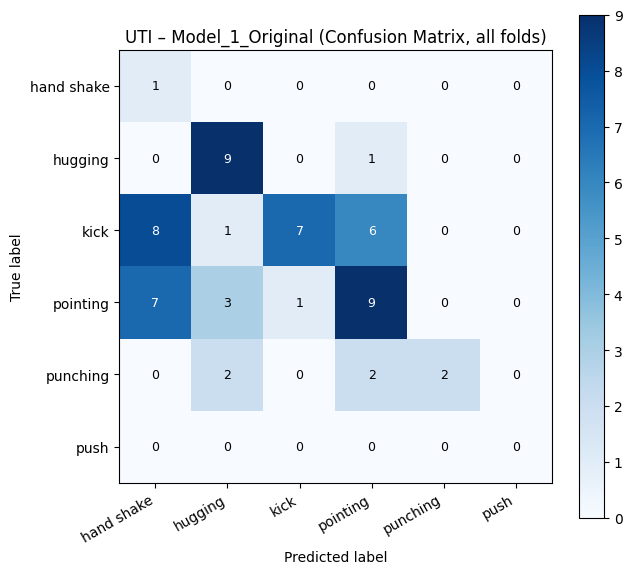

Model_1_Original: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_1_Original/cm_test_all_folds.png


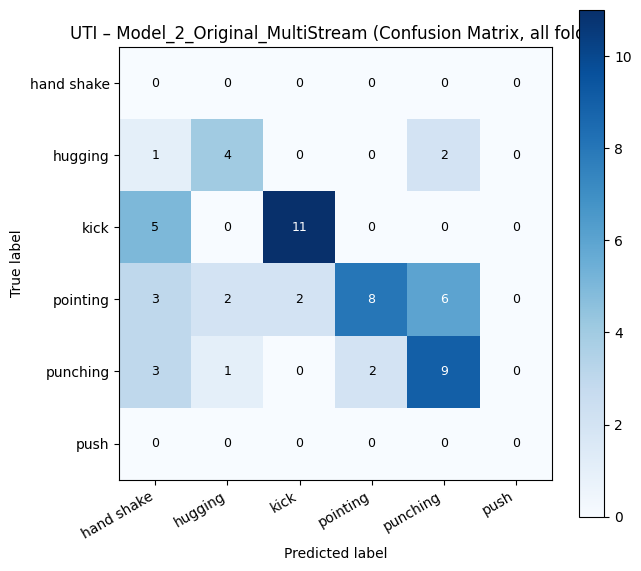

Model_2_Original_MultiStream: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_2_Original_MultiStream/cm_test_all_folds.png


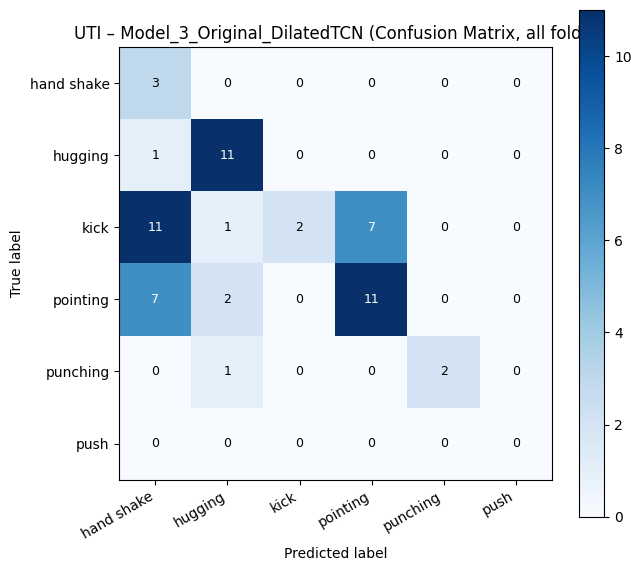

Model_3_Original_DilatedTCN: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_3_Original_DilatedTCN/cm_test_all_folds.png


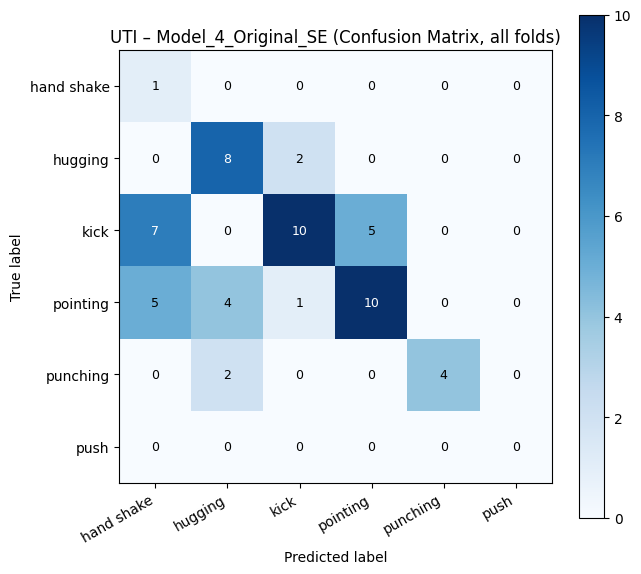

Model_4_Original_SE: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_4_Original_SE/cm_test_all_folds.png


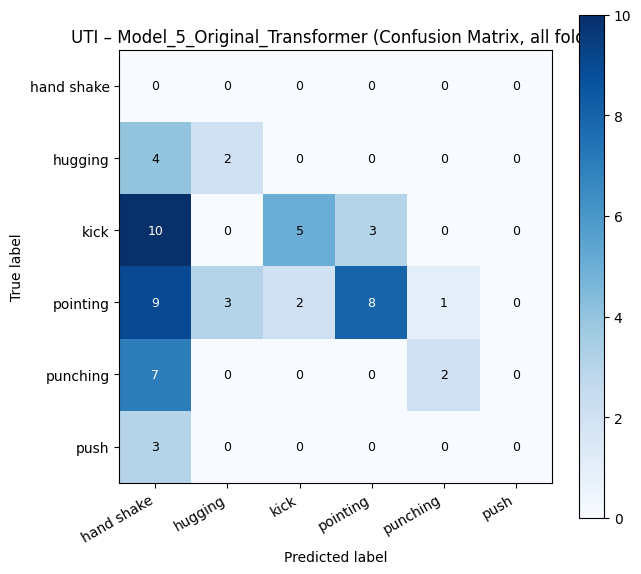

Model_5_Original_Transformer: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_5_Original_Transformer/cm_test_all_folds.png


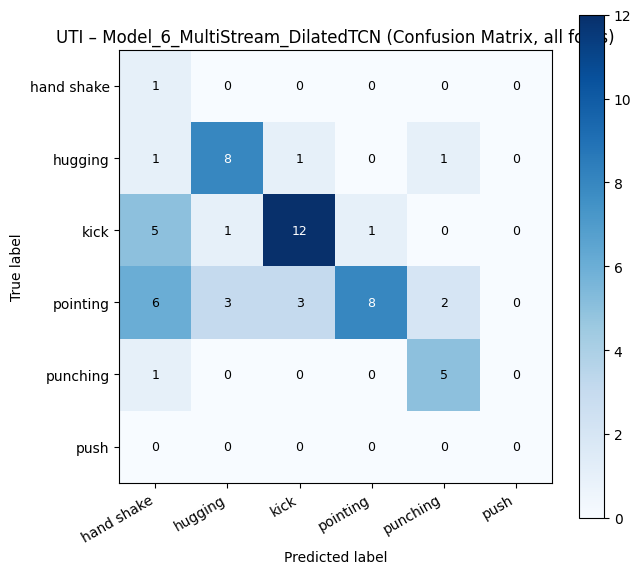

Model_6_MultiStream_DilatedTCN: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_6_MultiStream_DilatedTCN/cm_test_all_folds.png


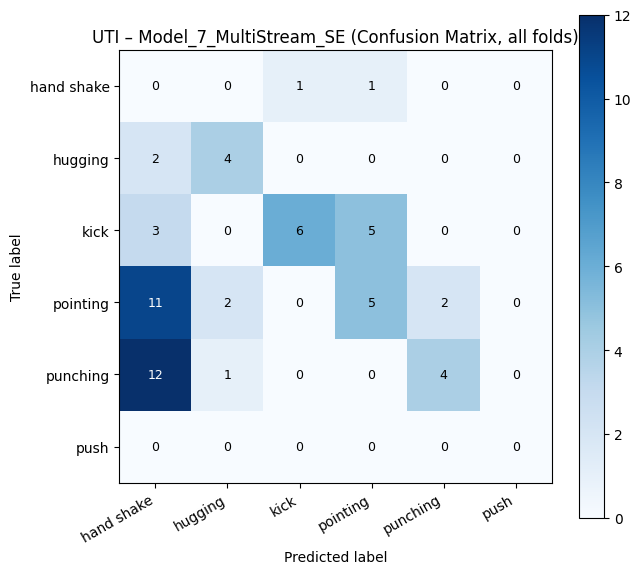

Model_7_MultiStream_SE: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_7_MultiStream_SE/cm_test_all_folds.png


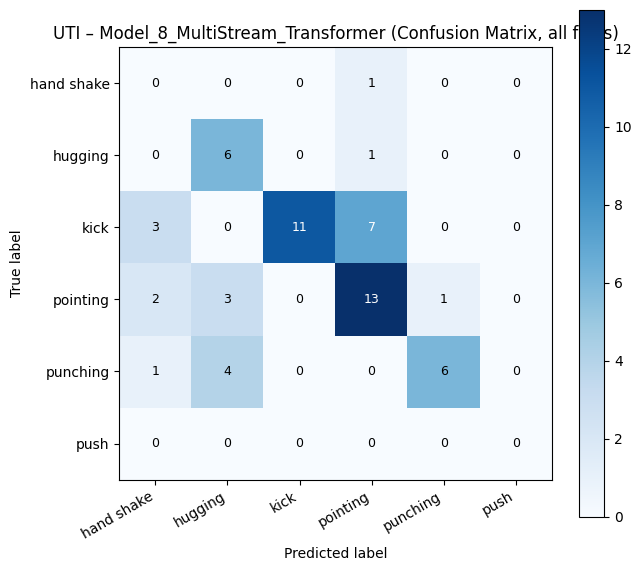

Model_8_MultiStream_Transformer: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_8_MultiStream_Transformer/cm_test_all_folds.png


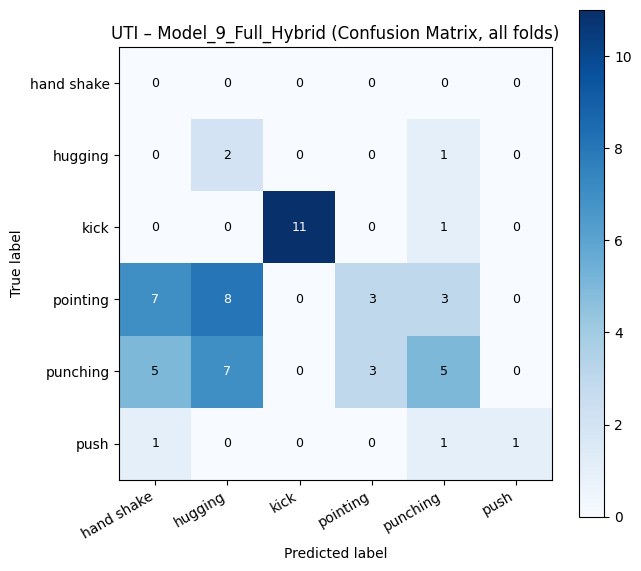

Model_9_Full_Hybrid: saved to /content/drive/MyDrive/ml_runs/_reports/uti_cm/aggregated/Model_9_Full_Hybrid/cm_test_all_folds.png


In [14]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
MODELS = [
    "Model_1_Original",
    "Model_2_Original_MultiStream",
    "Model_3_Original_DilatedTCN",
    "Model_4_Original_SE",
    "Model_5_Original_Transformer",
    "Model_6_MultiStream_DilatedTCN",
    "Model_7_MultiStream_SE",
    "Model_8_MultiStream_Transformer",
    "Model_9_Full_Hybrid",
]

labels = ["hand shake","hugging","kick","pointing","punching","push"]
N_CLASS = len(labels)

out_root = DRIVE_ROOT.parent / "_reports" / "uti_cm" / "aggregated"
out_root.mkdir(parents=True, exist_ok=True)

def load_cm(path: Path):
    p1 = path / "cm_test.csv"
    p2 = path / "confusion_matrix_test.csv"
    p = p1 if p1.exists() else p2
    if not p.exists():
        return None
    df = pd.read_csv(p, header=None)
    return df.values.astype(int)

for name in MODELS:
    total = np.zeros((N_CLASS, N_CLASS), dtype=int)
    found = False
    for k in range(1, 6):
        fold_dir = DRIVE_ROOT / "Models" / name / "outputs" / f"Fold{k}"
        if not fold_dir.exists():
            continue
        cm = load_cm(fold_dir)
        if cm is None:
            continue
        # pad if smaller
        if cm.shape[0] < N_CLASS:
            pad = np.zeros((N_CLASS, N_CLASS), dtype=int)
            pad[:cm.shape[0], :cm.shape[1]] = cm
            cm = pad
        total += cm
        found = True

    if not found:
        print(f"Skipped {name} (no cm found)")
        continue

    plt.figure(figsize=(6.8,6))
    plt.imshow(total, cmap="Blues")
    plt.colorbar()
    plt.xticks(np.arange(N_CLASS), labels, rotation=30, ha="right")
    plt.yticks(np.arange(N_CLASS), labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"UTI – {name} (Confusion Matrix, all folds)")
    vmax = total.max() if total.size else 0
    thr = vmax/2 if vmax>0 else 0.5
    for i in range(N_CLASS):
        for j in range(N_CLASS):
            v = int(total[i,j])
            plt.text(j, i, str(v), ha="center", va="center",
                     color=("white" if v>thr else "black"), fontsize=9)
    plt.tight_layout()
    save_dir = out_root / name
    save_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_dir / "cm_test_all_folds.png", dpi=150)
    plt.show()
    print(f"{name}: saved to {save_dir/'cm_test_all_folds.png'}")

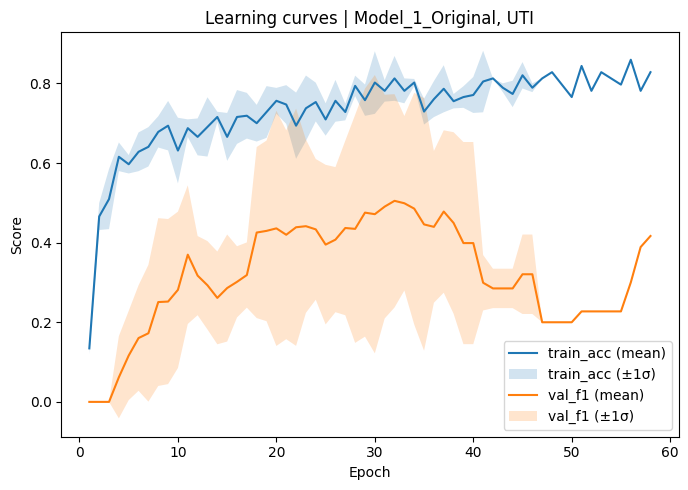

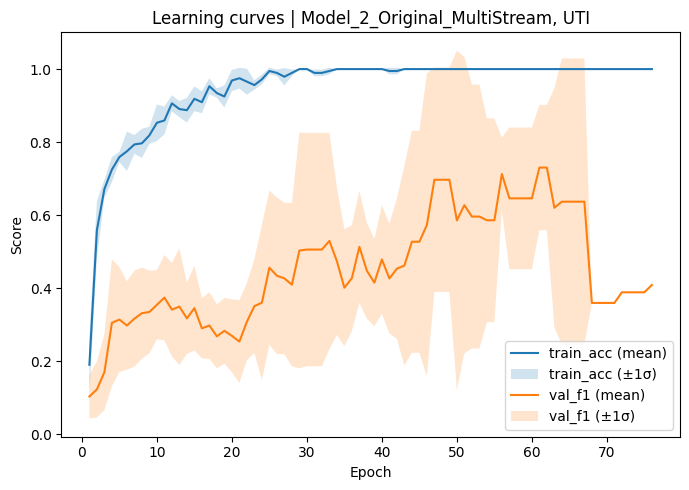

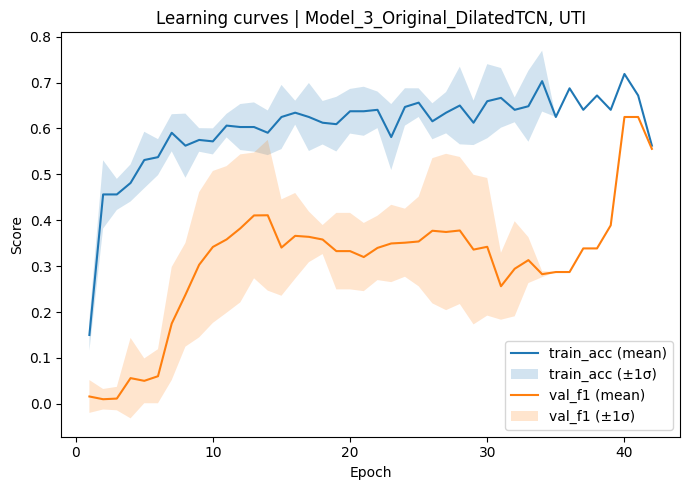

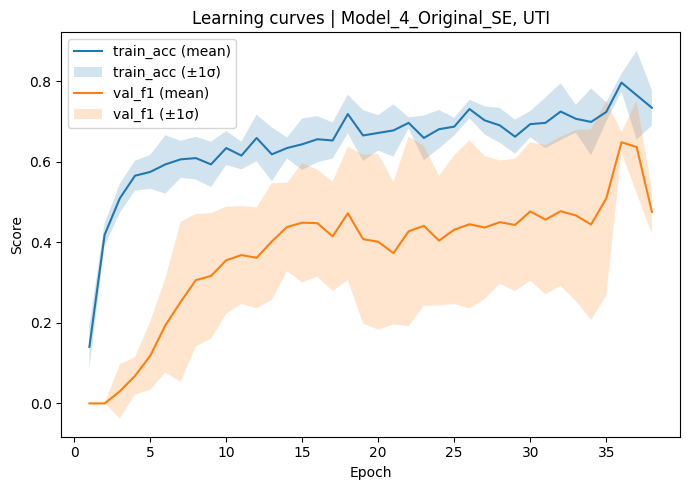

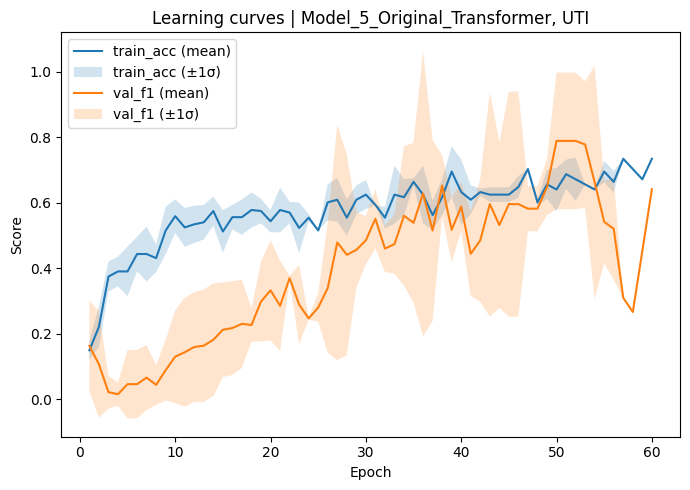

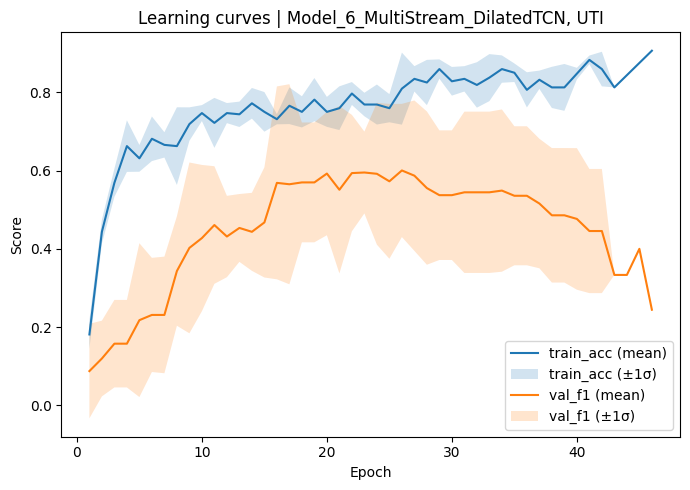

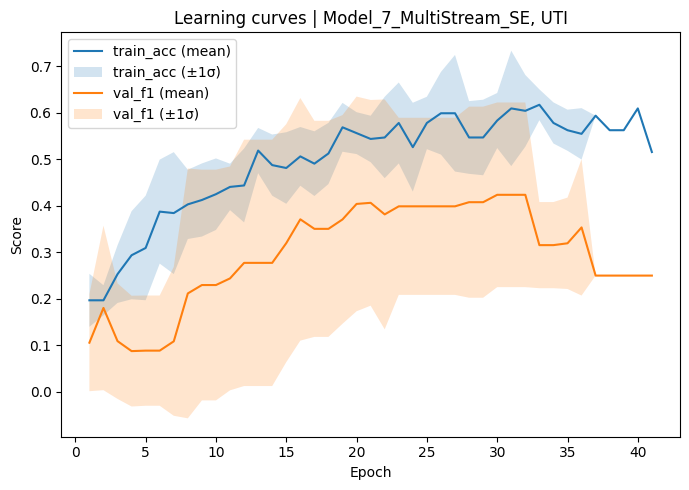

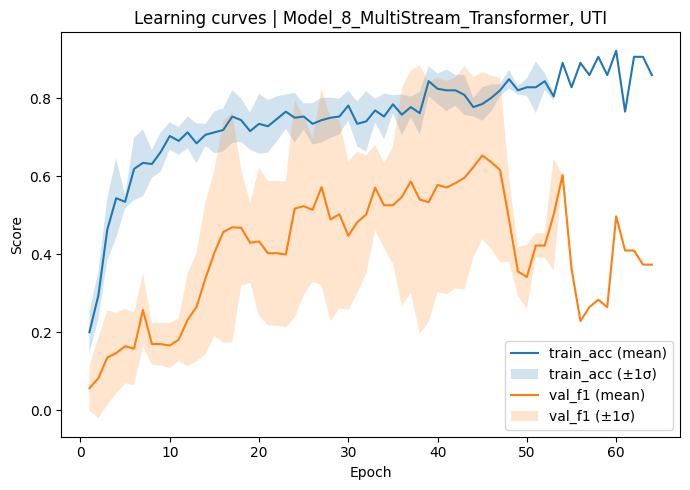

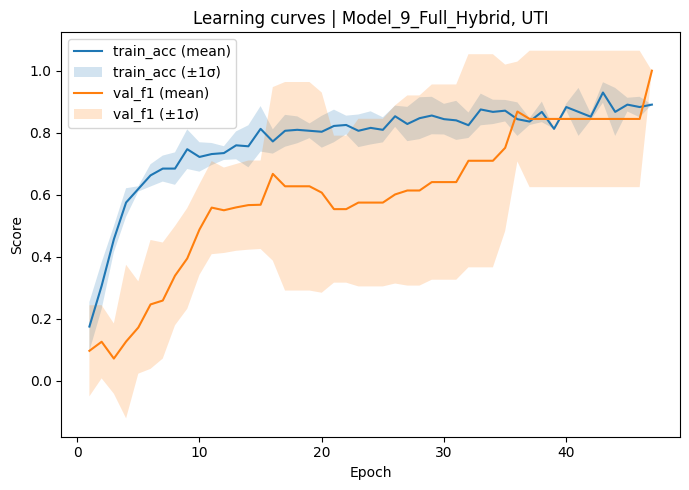

In [15]:
# /content/drive/MyDrive/ml_runs/uti_models/tools/plot_learning_curves_all_9.py
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
MODELS = [
    "Model_1_Original","Model_2_Original_MultiStream","Model_3_Original_DilatedTCN",
    "Model_4_Original_SE","Model_5_Original_Transformer","Model_6_MultiStream_DilatedTCN",
    "Model_7_MultiStream_SE","Model_8_MultiStream_Transformer","Model_9_Full_Hybrid",
]

def find_histories(model):
    base = DRIVE_ROOT / "Models" / model / "outputs"
    pats = [str(base / "Fold*/history.csv"), str(base / "fold*/history.csv")]
    files = []
    for p in pats: files.extend(glob.glob(p))
    return sorted(set(files))

def choose_val_f1(df):
    if "val_f1_macro" in df.columns: return df["val_f1_macro"]
    if "val_f1" in df.columns: return df["val_f1"]
    if "val_f1_weighted" in df.columns: return df["val_f1_weighted"]
    if "val_prec_macro" in df.columns and "val_rec_macro" in df.columns:
        p, r = df["val_prec_macro"], df["val_rec_macro"]
        f1 = (2*p*r)/(p+r).replace([np.inf, -np.inf], np.nan)
        return f1
    return None

def load_histories(model):
    dfs = []
    for fp in find_histories(model):
        try:
            df = pd.read_csv(fp)
        except Exception:
            continue
        if "epoch" not in df or "train_acc" not in df:
            continue
        vf = choose_val_f1(df)
        if vf is None:
            continue
        out = pd.DataFrame({"epoch": df["epoch"], "train_acc": df["train_acc"], "val_f1": vf})
        out = out.dropna(subset=["epoch","train_acc","val_f1"])
        if out.empty:
            continue
        dfs.append(out)
    return dfs

def aggregate(dfs):
    H = pd.concat(dfs, ignore_index=True)
    G = H.groupby("epoch", as_index=False).agg(
        train_acc_mean=("train_acc","mean"),
        train_acc_std =("train_acc","std"),
        val_f1_mean   =("val_f1","mean"),
        val_f1_std    =("val_f1","std"),
    ).sort_values("epoch")
    for c in ["train_acc_std","val_f1_std"]:
        if c in G: G[c] = G[c].fillna(0.0)
    return G

def plot_model(model):
    dfs = load_histories(model)
    if not dfs:
        print(f"skip: {model} (no usable history)");
        return
    A = aggregate(dfs)
    x  = A["epoch"].values
    ta = A["train_acc_mean"].values; ts = A["train_acc_std"].values
    vf = A["val_f1_mean"].values;    vs = A["val_f1_std"].values

    plt.figure(figsize=(7,5))
    plt.plot(x, ta, label="train_acc (mean)")
    plt.fill_between(x, ta-ts, ta+ts, alpha=0.2, label="train_acc (±1σ)")
    plt.plot(x, vf, label="val_f1 (mean)")
    plt.fill_between(x, vf-vs, vf+vs, alpha=0.2, label="val_f1 (±1σ)")
    plt.xlabel("Epoch"); plt.ylabel("Score")
    plt.title(f"Learning curves | {model}, UTI")
    plt.legend(); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    for m in MODELS:
        plot_model(m)

In [16]:
# /content/drive/MyDrive/ml_runs/uti_models/tools/aggregate_metrics_table.py
import pandas as pd, numpy as np
from pathlib import Path

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
MODELS = [
    "Model_1_Original",
    "Model_2_Original_MultiStream",
    "Model_3_Original_DilatedTCN",
    "Model_4_Original_SE",
    "Model_5_Original_Transformer",
    "Model_6_MultiStream_DilatedTCN",
    "Model_7_MultiStream_SE",
    "Model_8_MultiStream_Transformer",
    "Model_9_Full_Hybrid",
]
REPORT_NAME = "report_test.csv"

def read_fold_metrics(p: Path):
    if not p.exists():
        return None
    df = pd.read_csv(p, index_col=0)
    df.index = [str(i).strip().lower().replace(" ", "") for i in df.index]
    df.columns = [str(c).strip().lower().replace(" ", "") for c in df.columns]
    r = {}
    acc_col = "accuracy" if "accuracy" in df.columns else None
    if acc_col:
        for idx in ("precision","recall","f1-score","f1score","f1"):
            if idx in df.index and pd.notna(df.loc[idx, acc_col]):
                r["acc"] = float(df.loc[idx, acc_col]); break
    if "macroavg" in df.columns:
        if "precision" in df.index: r["prec_macro"] = float(df.loc["precision","macroavg"])
        if "recall"    in df.index: r["rec_macro"]  = float(df.loc["recall","macroavg"])
        for f1k in ("f1-score","f1score","f1"):
            if f1k in df.index:
                r["f1_macro"] = float(df.loc[f1k,"macroavg"]); break
    if "weightedavg" in df.columns:
        if "precision" in df.index: r["prec_weighted"] = float(df.loc["precision","weightedavg"])
        if "recall"    in df.index: r["rec_weighted"]  = float(df.loc["recall","weightedavg"])
        for f1k in ("f1-score","f1score","f1"):
            if f1k in df.index:
                r["f1_weighted"] = float(df.loc[f1k,"weightedavg"]); break
    return r if r else None

def summarize_model(model_name: str):
    rows = []
    for k in range(1,6):
        p = DRIVE_ROOT / "Models" / model_name / "outputs" / f"Fold{k}" / REPORT_NAME
        m = read_fold_metrics(p)
        if m: rows.append(m)
    if not rows:
        return pd.Series({c: np.nan for c in [
            "acc_mean","acc_std","prec_macro_mean","prec_macro_std",
            "rec_macro_mean","rec_macro_std","f1_macro_mean","f1_macro_std",
            "prec_weighted_mean","prec_weighted_std","rec_weighted_mean","rec_weighted_std",
            "f1_weighted_mean","f1_weighted_std"
        ]})
    df = pd.DataFrame(rows)
    out = {}
    for base in ["acc","prec_macro","rec_macro","f1_macro","prec_weighted","rec_weighted","f1_weighted"]:
        vals = df.get(base, pd.Series(dtype=float))
        out[f"{base}_mean"] = float(vals.mean(skipna=True)) if not vals.empty else np.nan
        out[f"{base}_std"]  = float(vals.std(ddof=0, skipna=True)) if not vals.empty else np.nan
    return pd.Series(out)

def main():
    recs = []
    for name in MODELS:
        s = summarize_model(name)
        s.name = name
        recs.append(s)
    table = pd.DataFrame(recs).reset_index().rename(columns={"index":"Model"})
    cols = ["Model","acc_mean","acc_std","prec_macro_mean","prec_macro_std",
            "rec_macro_mean","rec_macro_std","f1_macro_mean","f1_macro_std",
            "prec_weighted_mean","prec_weighted_std","rec_weighted_mean","rec_weighted_std",
            "f1_weighted_mean","f1_weighted_std"]
    table = table[cols]
    with pd.option_context('display.float_format', lambda x: f"{x:.4f}"):
        print(table.to_string(index=False))

if __name__ == "__main__":
    main()

                          Model  acc_mean  acc_std  prec_macro_mean  prec_macro_std  rec_macro_mean  rec_macro_std  f1_macro_mean  f1_macro_std  prec_weighted_mean  prec_weighted_std  rec_weighted_mean  rec_weighted_std  f1_weighted_mean  f1_weighted_std
               Model_1_Original    0.4727   0.1299           0.5185          0.1311          0.4700         0.1496         0.4298        0.1010              0.6406             0.1835             0.4727            0.1299            0.4849           0.1064
   Model_2_Original_MultiStream    0.5424   0.1236           0.4935          0.1418          0.4062         0.0970         0.4076        0.1244              0.7028             0.2208             0.5424            0.1236            0.5548           0.1734
    Model_3_Original_DilatedTCN    0.4909   0.1406           0.4517          0.0668          0.5033         0.1376         0.4327        0.0826              0.5183             0.1142             0.4909            0.1406            0.46


Model Ranking (Best → Worst) based on F1-macro:

 Rank                           Model  f1_macro_mean  acc_mean  prec_macro_mean  rec_macro_mean  f1_macro_std  acc_std  prec_macro_std  rec_macro_std  f1_weighted_mean  prec_weighted_mean  rec_weighted_mean
    1             Model_4_Original_SE         0.4814    0.5576           0.5729          0.5158        0.0737   0.1859          0.0699         0.1009            0.5756              0.7219             0.5576
    2 Model_8_MultiStream_Transformer         0.4591    0.6121           0.4854          0.4927        0.0677   0.0873          0.1397         0.0691            0.5948              0.6511             0.6121
    3  Model_6_MultiStream_DilatedTCN         0.4459    0.5758           0.5277          0.4638        0.0946   0.1035          0.0779         0.1461            0.6009              0.7542             0.5758
    4     Model_3_Original_DilatedTCN         0.4327    0.4909           0.4517          0.5033        0.0923   0.1572    

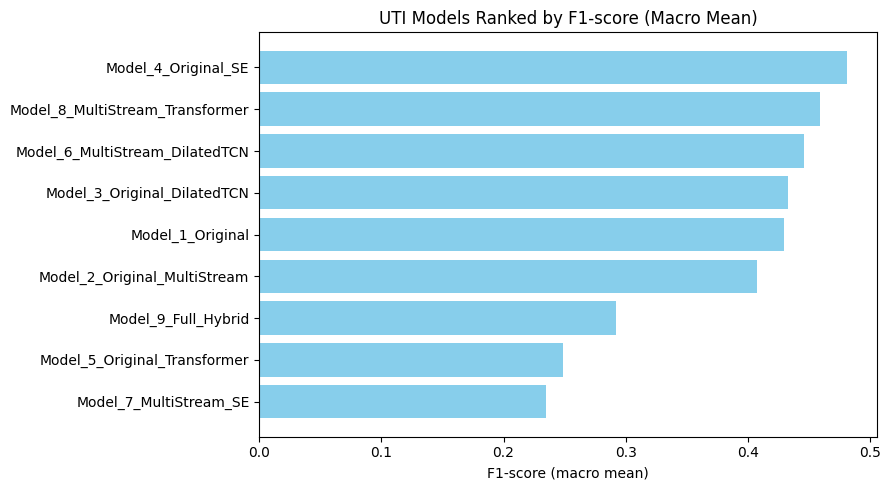

In [17]:
# /content/drive/MyDrive/ml_runs/uti_models/tools/rank_models_uti.py

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DRIVE_ROOT = Path("/content/drive/MyDrive/ml_runs/uti_models")
MODELS = [
    "Model_1_Original",
    "Model_2_Original_MultiStream",
    "Model_3_Original_DilatedTCN",
    "Model_4_Original_SE",
    "Model_5_Original_Transformer",
    "Model_6_MultiStream_DilatedTCN",
    "Model_7_MultiStream_SE",
    "Model_8_MultiStream_Transformer",
    "Model_9_Full_Hybrid",
]

def _norm_cols(s):
    return (
        s.lower()
         .replace(" ", "")
         .replace("-", "")
         .replace("_", "")
    )

def load_fold_metrics(model: str, k: int):
    p = DRIVE_ROOT / "Models" / model / "outputs" / f"Fold{k}" / "report_test.csv"
    if not p.exists():
        return None
    df = pd.read_csv(p, index_col=0)
    df.index = [_norm_cols(i) for i in df.index]
    df.columns = [_norm_cols(c) for c in df.columns]

    row_f1 = "f1score" if "f1score" in df.index else ("f1" if "f1" in df.index else None)
    if row_f1 is None or "precision" not in df.index or "recall" not in df.index:
        return None

    col_macro = "macroavg" if "macroavg" in df.columns else None
    col_weighted = "weightedavg" if "weightedavg" in df.columns else None
    col_acc = "accuracy" if "accuracy" in df.columns else None
    if not all([col_macro, col_weighted, col_acc]):
        return None

    try:
        acc = float(df.loc["precision", col_acc])
    except Exception:
        acc = np.nan

    try:
        prec_macro = float(df.loc["precision", col_macro])
        rec_macro  = float(df.loc["recall", col_macro])
        f1_macro   = float(df.loc[row_f1, col_macro])
        prec_w     = float(df.loc["precision", col_weighted])
        rec_w      = float(df.loc["recall", col_weighted])
        f1_w       = float(df.loc[row_f1, col_weighted])
    except Exception:
        return None

    return {
        "acc": acc,
        "prec_macro": prec_macro,
        "rec_macro": rec_macro,
        "f1_macro": f1_macro,
        "prec_weighted": prec_w,
        "rec_weighted": rec_w,
        "f1_weighted": f1_w,
    }

def summarize_model(model: str):
    rows = []
    for k in range(1, 6):
        m = load_fold_metrics(model, k)
        if m is not None:
            rows.append(m)
    if not rows:
        return None
    df = pd.DataFrame(rows)
    out = {
        "Model": model,
        "acc_mean": df["acc"].mean(),
        "acc_std": df["acc"].std(),
        "prec_macro_mean": df["prec_macro"].mean(),
        "prec_macro_std": df["prec_macro"].std(),
        "rec_macro_mean": df["rec_macro"].mean(),
        "rec_macro_std": df["rec_macro"].std(),
        "f1_macro_mean": df["f1_macro"].mean(),
        "f1_macro_std": df["f1_macro"].std(),
        "prec_weighted_mean": df["prec_weighted"].mean(),
        "prec_weighted_std": df["prec_weighted"].std(),
        "rec_weighted_mean": df["rec_weighted"].mean(),
        "rec_weighted_std": df["rec_weighted"].std(),
        "f1_weighted_mean": df["f1_weighted"].mean(),
        "f1_weighted_std": df["f1_weighted"].std(),
    }
    return out

def main():
    summaries = []
    for m in MODELS:
        s = summarize_model(m)
        if s is not None:
            summaries.append(s)

    if not summaries:
        print("No summaries found.")
        return

    S = pd.DataFrame(summaries)
    S = S.sort_values("f1_macro_mean", ascending=False).reset_index(drop=True)
    S.insert(0, "Rank", np.arange(1, len(S) + 1))

    cols_print = [
        "Rank","Model","f1_macro_mean","acc_mean","prec_macro_mean","rec_macro_mean",
        "f1_macro_std","acc_std","prec_macro_std","rec_macro_std",
        "f1_weighted_mean","prec_weighted_mean","rec_weighted_mean"
    ]
    S_print = S[cols_print].copy()

    with pd.option_context("display.max_columns", None, "display.width", 160):
        print("\nModel Ranking (Best → Worst) based on F1-macro:\n")
        print(S_print.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # --- BAR CHART (sky blue, no labels) ---
    plt.figure(figsize=(9, 5))
    plt.barh(S["Model"], S["f1_macro_mean"], color="skyblue")
    plt.xlabel("F1-score (macro mean)")
    plt.title("UTI Models Ranked by F1-score (Macro Mean)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()